In [1]:
!pip install fuzzywuzzy

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import heapq
import random

from tqdm import tqdm
from fuzzywuzzy import fuzz, process
from datetime import datetime, timedelta

C:\Users\nikol\AppData\Roaming\Python\Python38\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def read_pajek(file_path, label_parser=None):
    with open(file_path, encoding="UTF-8") as file:
        file.readline()  # skip header
        nodes = []  # OPT pre-allocate given header

        for line in file:
            if line.startswith("*"):
                directive = line.split()[0][1:]
                if directive == "edges":
                    G = nx.MultiGraph(name="LPP")
                elif directive == "arcs":
                    G = nx.MultiDiGraph(name="LPP")
                else:
                    raise SyntaxError(f"invalid link type: {directive}")
                break
            else:  # add node
                parts = line.strip().split("\"")
                if len(parts) == 3:
                    num, lab, val = parts
                    nodes.append((int(num), {"label": lab, "lat": val.strip().split(" ")[0], "lon": val.strip().split(" ")[1]}))
                elif len(parts) == 5:
                    num, lab, val, node_type, _ = parts
                    if val.strip():
                        nodes.append((int(num), {"label": lab, "lat": val.strip().split(" ")[0], "lon": val.strip().split(" ")[1], "type": node_type}))
                    else:
                        nodes.append((int(num), {"label": lab, "type": node_type}))

        G.add_nodes_from(nodes)

        for line in file:
            parts = line.split()
            if len(parts) == 2:
                i, j = parts
                G.add_edge(int(i), int(j))
            elif len(parts) == 3:
                i, j, val = parts
                G.add_edge(int(i), int(j), label=int(val))

    return G

In [3]:
def save_graph_as_net(G, file_path):
    with open(file_path, 'w') as f:
        f.write('*vertices {}\n'.format(G.number_of_nodes()))
        for node, data in G.nodes(data=True):
            label = data.get('label', node)
            if not data:
                print(data)
            if data["type"] == "station":
                lat = data.get('lat', 0.0)
                lon = data.get('lon', 0.0)
                f.write('{} "{}" {} {} "station"\n'.format(node, label, lat, lon))
            else:
                f.write('{} "{}" "{}"\n'.format(node, label, data["type"]))

        f.write('*edges {}\n'.format(G.number_of_edges()))
        for u, v, data in G.edges(data=True):
            f.write('{} {} {}\n'.format(u, v, data['label']))

In [4]:
G = read_pajek("./LPP_distances.net")

In [5]:
def get_station_id(data, stops_df):
    best_match = process.extractOne(data['label'], stops_df['stop_name'].values, scorer=fuzz.partial_ratio)
    return stops_df[stops_df['stop_name'] == best_match[0]]['stop_id'].iloc[0]

In [6]:
def preprocess_time_string(time_str):
    parts = time_str.split(':')
    if int(parts[0]) >= 24:
        hours = int(parts[0]) - 24
        return f'{hours:02}:{parts[1]}:{parts[2]}'
    return time_str

In [7]:
def get_soonest_arrivals(df, current_time):
    df = df.copy()
    df['arrival_time'] = df['arrival_time'].apply(preprocess_time_string)
    df['arrival_time'] = pd.to_datetime(df['arrival_time'], format='%H:%M:%S').apply(
        lambda x: x.replace(year=datetime.now().year, month=datetime.now().month, day=datetime.now().day))
    current_time = pd.to_datetime(current_time, format='%H:%M:%S').replace(year=datetime.now().year,
                                                                           month=datetime.now().month,
                                                                           day=datetime.now().day)
    df.loc[df['arrival_time'] < current_time, 'arrival_time'] += timedelta(days=1)
    df = df[df['arrival_time'] > current_time]
    return df.loc[df.groupby('trip_id')['arrival_time'].idxmin()]

In [26]:
def k_shortest_paths(G, source, target, paths_num):
    paths = []
    
    for _ in range(paths_num):
        try:
            path = nx.dijkstra_path(G, source, target, weight="weight")

            total_weight = 0
            total_distance = 0
            total_time = 0
            bus_and_route = []
            
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                edge_data = G.get_edge_data(u, v)

                min_key = min(edge_data, key=lambda key: edge_data[key]['weight'])
                total_weight += edge_data[min_key]['weight']
                total_distance += edge_data[min_key]['distance']
                total_time += edge_data[min_key]['time']
                bus_and_route.append((edge_data[min_key]['bus'], edge_data[min_key]['route']))
                
                G.remove_edge(u, v, key=min_key)

            paths.append({
                "weight": total_weight,
                "distance": total_distance,
                "time": total_time,
                "buses_and_routes": bus_and_route,
                "stations": path
            })
        except nx.NetworkXNoPath:
            break
    
    return paths

In [35]:
def optimal_paths(G, start_station, end_station, alpha, paths_num = 5, limit=20, seed=None):
    if seed is not None:
        random.seed(seed)
        
    stops_df = pd.read_csv('./stops.txt')
    trips_df = pd.read_csv('./trips.txt')
    routes_df = pd.read_csv('./routes.txt')
    stop_times_df = pd.read_csv('./stop_times.txt')
    current_time = datetime.now().strftime('%H:%M:%S')

    weighted_G = nx.MultiGraph()
    nodes_data = list(G.nodes(data=True))
    node_map = {node: data for node, data in nodes_data}

    start_node, end_node = None, None
    for node, data in tqdm(list(G.nodes(data=True)), desc="Generating new graph"):
        weighted_G.add_node(node, **data)

        if data["label"] == start_station:
            start_node = node
        elif data["label"] == end_station:
            end_node = node

    for u, v, data in tqdm(list(G.edges(data=True)), desc="Adding weights to edges"):
        distance = int(data["label"])
        u_data = node_map[u]
        v_data = node_map[v]

        # Get id of the station from the txt files
        u_station_id = get_station_id(u_data, stops_df)
        v_station_id = get_station_id(v_data, stops_df)

        # Get the timetables for all buses that stop at these stops
        u_stops = stop_times_df[stop_times_df['stop_id'] == u_station_id]
        v_stops = stop_times_df[stop_times_df['stop_id'] == v_station_id]

        # Get one timetable for each bus that stops at these stops and arrive the soonest
        u_soonest_stops = get_soonest_arrivals(u_stops, current_time)
        v_soonest_stops = get_soonest_arrivals(v_stops, current_time)

        # Find buses that stop at both stations
        common_trip_ids = set(u_soonest_stops['trip_id']).intersection(set(v_soonest_stops['trip_id']))
        if len(common_trip_ids) > limit:
            common_trip_ids = random.sample(common_trip_ids, limit)
        
        for trip_id in common_trip_ids:
            # Extract the arrival time at both stations
            u_arrival_time = u_soonest_stops.loc[u_soonest_stops['trip_id'] == trip_id, 'arrival_time'].values[0]
            v_arrival_time = v_soonest_stops.loc[v_soonest_stops['trip_id'] == trip_id, 'arrival_time'].values[0]
            
            # Extract the used bus and route for the current trip
            bus = trips_df.loc[trips_df['trip_id'] == trip_id, "trip_headsign"].values[0]
            route_id = trips_df.loc[trips_df['trip_id'] == trip_id, "route_id"].values[0]
            route = routes_df.loc[routes_df["route_id"] == route_id, "route_short_name"].values[0]

            # Calculate the absolute travel time in minutes
            travel_time_delta = pd.Timestamp(v_arrival_time) - pd.Timestamp(u_arrival_time)
            travel_time_minutes = abs(travel_time_delta.total_seconds() // 60)
            
            # Calulcate weight as a weighted average of the distance and the time
            weight = alpha * distance + (1 - alpha) * travel_time_minutes
            
            # Add the new edge with calculated travel time and other relevant attributes
            weighted_G.add_edge(u, v, weight=weight, distance=distance, time=travel_time_minutes, bus=bus, route=route)
        
    
    return weighted_G, k_shortest_paths(weighted_G, start_node, end_node, paths_num)

In [41]:
G_weighted, paths_5 = optimal_paths(G, "Nove Jarše-Šmartinska", "Leskoškova", 0, seed=42)

Adding weights to edges: 100%|███████████████████████████████████████████████████████| 563/563 [06:45<00:00,  1.39it/s]


In [42]:
paths_5

[{'weight': 6.0,
  'distance': 2416,
  'time': 6.0,
  'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'),
   ('LETALIŠKA - PRŽAN', '7L'),
   ('LETALIŠKA - PRŽAN', '7L'),
   ('LETALIŠKA - PRŽAN', '7L')],
  'stations': [31, 30, 132, 133, 134]},
 {'weight': 7.0,
  'distance': 2416,
  'time': 7.0,
  'buses_and_routes': [('VEVČE - BEŽIGRAD', '12'),
   ('LETALIŠKA - PRŽAN', '7L'),
   ('LETALIŠKA - PRŽAN', '7L'),
   ('LETALIŠKA - PRŽAN', '7L')],
  'stations': [31, 30, 132, 133, 134]},
 {'weight': 7.0,
  'distance': 2416,
  'time': 7.0,
  'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7'),
   ('LETALIŠKA - PRŽAN', '7L'),
   ('LETALIŠKA - PRŽAN', '7L'),
   ('LETALIŠKA - PRŽAN', '7L')],
  'stations': [31, 30, 132, 133, 134]},
 {'weight': 8.0,
  'distance': 2416,
  'time': 8.0,
  'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'),
   ('LETALIŠKA - PRŽAN', '7L'),
   ('LETALIŠKA - PRŽAN', '7L'),
   ('LETALIŠKA - PRŽAN', '7L')],
  'stations': [31, 30, 132, 133, 134]},
 {'we

In [34]:
for i in tqdm(G_weighted.nodes(), desc="Finding paths"):
    for j in range(i+1, G_weighted.number_of_nodes() + 1):
        if i != j:
            paths = k_shortest_paths(G_weighted.copy(), i, j, 10)
            if len(paths) != 0:
                print(paths)

Finding paths:   0%|                                                                           | 0/320 [00:00<?, ?it/s]

[{'weight': 710.5, 'distance': 1417, 'time': 4.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [1, 2]}]
[{'weight': 1011.5, 'distance': 2018, 'time': 5.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [1, 2, 3]}]
[{'weight': 1550.5, 'distance': 3095, 'time': 6.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [1, 2, 3, 4]}]


Finding paths:   0%|▏                                                                  | 1/320 [00:00<02:54,  1.83it/s]

[{'weight': 1645.0, 'distance': 3286, 'time': 4.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [1, 235, 234]}]
[{'weight': 871.0, 'distance': 1738, 'time': 4.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [1, 235]}]
[{'weight': 301.0, 'distance': 601, 'time': 1.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [2, 3]}]
[{'weight': 840.0, 'distance': 1678, 'time': 2.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [2, 3, 4]}]


Finding paths:   1%|▍                                                                  | 2/320 [00:01<02:48,  1.89it/s]

[{'weight': 2355.5, 'distance': 4703, 'time': 8.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [2, 1, 235, 234]}]
[{'weight': 1581.5, 'distance': 3155, 'time': 8.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [2, 1, 235]}]
[{'weight': 539.0, 'distance': 1077, 'time': 1.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [3, 4]}]


Finding paths:   1%|▋                                                                  | 3/320 [00:01<02:45,  1.92it/s]

[{'weight': 2656.5, 'distance': 5304, 'time': 9.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [3, 2, 1, 235, 234]}]
[{'weight': 1882.5, 'distance': 3756, 'time': 9.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [3, 2, 1, 235]}]


Finding paths:   1%|▊                                                                  | 4/320 [00:02<02:44,  1.93it/s]

[{'weight': 3195.5, 'distance': 6381, 'time': 10.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [4, 3, 2, 1, 235, 234]}]
[{'weight': 2421.5, 'distance': 4833, 'time': 10.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [4, 3, 2, 1, 235]}]
[{'weight': 212.5, 'distance': 424, 'time': 1.0, 'buses_and_routes': [('STANEŽIČE P+R - DOLGI MOST P+R', '1')], 'stations': [5, 6]}]
[{'weight': 445.5, 'distance': 888, 'time': 3.0, 'buses_and_routes': [('STANEŽIČE P+R - DOLGI MOST P+R', '1'), ('STANEŽIČE P+R - DOLGI MOST P+R', '1')], 'stations': [5, 6, 7]}]


Finding paths:   2%|█                                                                  | 5/320 [00:02<02:44,  1.91it/s]

[{'weight': 233.0, 'distance': 464, 'time': 2.0, 'buses_and_routes': [('STANEŽIČE P+R - DOLGI MOST P+R', '1')], 'stations': [6, 7]}]


Finding paths:   3%|█▉                                                                 | 9/320 [00:04<02:41,  1.92it/s]

[{'weight': 166.5, 'distance': 332, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [10, 11]}, {'weight': 167.0, 'distance': 332, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [10, 11]}]
[{'weight': 342.0, 'distance': 682, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - B.D. - STANEŽIČE P+R - GAMELJNE', 'N1')], 'stations': [10, 11, 12]}, {'weight': 342.5, 'distance': 682, 'time': 3.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [10, 11, 12]}]


Finding paths:   3%|██                                                                | 10/320 [00:05<02:41,  1.91it/s]

[{'weight': 175.5, 'distance': 350, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - B.D. - STANEŽIČE P+R - GAMELJNE', 'N1')], 'stations': [11, 12]}, {'weight': 175.5, 'distance': 350, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [11, 12]}]


Finding paths:   4%|██▍                                                               | 12/320 [00:06<02:38,  1.94it/s]

[{'weight': 202.0, 'distance': 403, 'time': 1.0, 'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27')], 'stations': [13, 14]}, {'weight': 202.0, 'distance': 403, 'time': 1.0, 'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27')], 'stations': [13, 14]}, {'weight': 202.0, 'distance': 403, 'time': 1.0, 'buses_and_routes': [('TOMAČEVO - IŠKA VAS (obvoz)', '19I')], 'stations': [13, 14]}, {'weight': 202.0, 'distance': 403, 'time': 1.0, 'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK', '27')], 'stations': [13, 14]}, {'weight': 202.0, 'distance': 403, 'time': 1.0, 'buses_and_routes': [('TOMAČEVO - BARJE', '19')], 'stations': [13, 14]}, {'weight': 202.5, 'distance': 403, 'time': 2.0, 'buses_and_routes': [('STANEŽIČE P+R - DOLGI MOST P+R', '1')], 'stations': [13, 14]}, {'weight': 202.5, 'distance': 403, 'time': 2.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [13, 14]}, {'weight': 202.5, 'distance': 403, 'time': 2.0, 'buses_and_routes': [('ŠTEP

Finding paths:   4%|██▋                                                               | 13/320 [00:06<02:39,  1.93it/s]

[{'weight': 399.5, 'distance': 796, 'time': 3.0, 'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'), ('SAVLJE - BOKALCE', '14')], 'stations': [13, 14, 219]}, {'weight': 400.0, 'distance': 796, 'time': 4.0, 'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'), ('SAVLJE - BOKALCE', '14')], 'stations': [13, 14, 219]}]
[{'weight': 679.5, 'distance': 1355, 'time': 4.0, 'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'), ('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [13, 14, 219, 220]}, {'weight': 680.5, 'distance': 1355, 'time': 6.0, 'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'), ('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [13, 14, 219, 220]}]
[{'weight': 358.5, 'distance': 715, 'time': 2.0, 'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'), ('JEŽICA P+R - ZALOG', '11')], 'stations': [14, 13, 48]}, {'weight': 358.5, 'distance': 715, 'time': 2.0, 'buses_and_routes': [('LE

Finding paths:   4%|██▉                                                               | 14/320 [00:07<02:40,  1.91it/s]

[{'weight': 197.5, 'distance': 393, 'time': 2.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [14, 219]}, {'weight': 198.0, 'distance': 393, 'time': 3.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [14, 219]}]
[{'weight': 477.5, 'distance': 952, 'time': 3.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [14, 219, 220]}, {'weight': 478.5, 'distance': 952, 'time': 5.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [14, 219, 220]}]
[{'weight': 102.5, 'distance': 203, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B')], 'stations': [15, 16]}, {'weight': 102.5, 'distance': 203, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [15, 16]}]
[{'weight': 477.0, 'distance': 951, 'time': 3.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('NOVE JARŠE - PRŽAN', '7')], 'stations'

Finding paths:   5%|███                                                               | 15/320 [00:07<02:41,  1.89it/s]

[{'weight': 1363.0, 'distance': 2720, 'time': 6.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('NOVE JARŠE - PRŽAN', '7'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [15, 16, 17, 18, 19, 289]}]
[{'weight': 374.5, 'distance': 748, 'time': 1.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7')], 'stations': [16, 17]}, {'weight': 375.0, 'distance': 748, 'time': 2.0, 'buses_and_routes': [('ŠTEPANJSKO NASELJE - PODUTIK', '5')], 'stations': [16, 17]}, {'weight': 375.0, 'distance': 748, 'time': 2.0, 'buses_and_routes': [('LETALIŠKA - PRŽAN', '7L')], 'stations': [16, 17]}, {'weight': 375.0, 'distance': 748, 'time': 2.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8')], 'stations': [16, 17]}, {'weight': 375.0, 'distance': 748, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [16, 17]}, {'weight': 375.0, 'distance': 748, 'time': 2.0, 'bu

Finding paths:   5%|███▎                                                              | 16/320 [00:08<02:37,  1.92it/s]

[{'weight': 1531.0, 'distance': 3054, 'time': 8.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('ZALOG - NOVE STOŽICE P+R', '20Z'), ('FUŽINE P+R - NOVE STOŽICE P+R', '20')], 'stations': [16, 15, 49, 106, 129, 195]}, {'weight': 1531.5, 'distance': 3054, 'time': 9.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('DOLGI MOST P+R - ČRNUČE', '6'), ('PRŽAN - NOVE JARŠE', '7'), ('FUŽINE P+R - NOVE STOŽICE P+R', '20'), ('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [16, 15, 49, 106, 129, 195]}]
[{'weight': 1260.5, 'distance': 2517, 'time': 4.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [16, 17, 18, 19, 289]}]
[{'weight': 210.0, 'distance': 419, 'time': 1.0, 'buses_and_routes': [('BAVARSKI DVOR - STANEŽIČE P+R', 'N1')], 'stations': [17, 18]}, {'weight

Finding paths:   5%|███▌                                                              | 17/320 [00:08<02:35,  1.94it/s]

[{'weight': 379.5, 'distance': 758, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [18, 19]}, {'weight': 380.0, 'distance': 758, 'time': 2.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25')], 'stations': [18, 19]}, {'weight': 380.0, 'distance': 758, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [18, 19]}, {'weight': 380.5, 'distance': 758, 'time': 3.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [18, 19]}, {'weight': 380.5, 'distance': 758, 'time': 3.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25')], 'stations': [18, 19]}]
[{'weight': 630.0, 'distance': 1258, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [18, 19, 20]}, {'weight': 631.0, 'distance': 1258, 'time': 4.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25')], 'stations': [18, 19, 20]}, {'weight

Finding paths:   6%|███▋                                                              | 18/320 [00:09<02:34,  1.95it/s]

[{'weight': 676.0, 'distance': 1350, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [18, 19, 289]}]
[{'weight': 250.5, 'distance': 500, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [19, 20]}, {'weight': 251.0, 'distance': 500, 'time': 2.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25')], 'stations': [19, 20]}, {'weight': 251.0, 'distance': 500, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [19, 20]}, {'weight': 251.5, 'distance': 500, 'time': 3.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [19, 20]}, {'weight': 251.5, 'distance': 500, 'time': 3.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [19, 20]}, {'weight': 252.0, 'distance': 500, 'time': 4.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [19, 20]}]
[{'weight': 1245.0, 'distan

Finding paths:   6%|███▉                                                              | 19/320 [00:09<02:34,  1.95it/s]

[{'weight': 2495.0, 'distance': 4979, 'time': 11.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('NOVE JARŠE - PRŽAN', '7'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('ZALOG - NOVE STOŽICE P+R', '20Z'), ('FUŽINE P+R - NOVE STOŽICE P+R', '20')], 'stations': [19, 18, 17, 16, 15, 49, 106, 129, 195]}, {'weight': 2497.0, 'distance': 4979, 'time': 15.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25'), ('ŠTEPANJSKO NASELJE - PODUTIK', '5'), ('ŠTEPANJSKO NASELJE - PODUTIK', '5'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('DOLGI MOST P+R - ČRNUČE', '6'), ('PRŽAN - NOVE JARŠE', '7'), ('FUŽINE P+R - NOVE STOŽICE P+R', '20'), ('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [19, 18, 17, 16, 15, 49, 106, 129, 195]}]
[{'weight': 296.5, 'distance': 592, 'time': 1.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [19, 289]}]
[{'weight': 1495.5, 'd

Finding paths:   6%|████▏                                                             | 20/320 [00:10<02:33,  1.95it/s]

[{'weight': 2745.5, 'distance': 5479, 'time': 12.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('NOVE JARŠE - PRŽAN', '7'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('ZALOG - NOVE STOŽICE P+R', '20Z'), ('FUŽINE P+R - NOVE STOŽICE P+R', '20')], 'stations': [20, 19, 18, 17, 16, 15, 49, 106, 129, 195]}, {'weight': 2748.0, 'distance': 5479, 'time': 17.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('ŠTEPANJSKO NASELJE - PODUTIK', '5'), ('ŠTEPANJSKO NASELJE - PODUTIK', '5'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('DOLGI MOST P+R - ČRNUČE', '6'), ('PRŽAN - NOVE JARŠE', '7'), ('FUŽINE P+R - NOVE STOŽICE P+R', '20'), ('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [20, 19, 18, 17, 16, 15, 49, 106, 129, 195]}]
[{'weight': 547.0, 'distance': 1092, 'time': 2.0, 'buses_and_routes': [('D

Finding paths:   7%|████▎                                                             | 21/320 [00:10<02:33,  1.95it/s]

[{'weight': 215.5, 'distance': 430, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [22, 23]}, {'weight': 215.5, 'distance': 430, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [22, 23]}]
[{'weight': 536.0, 'distance': 1071, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('BAVARSKI DVOR - STANEŽIČE P+R - BROD', 'N1')], 'stations': [22, 23, 24]}, {'weight': 536.5, 'distance': 1071, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [22, 23, 24]}]


Finding paths:   7%|████▌                                                             | 22/320 [00:11<02:33,  1.94it/s]

[{'weight': 320.5, 'distance': 641, 'time': 0.0, 'buses_and_routes': [('BAVARSKI DVOR - STANEŽIČE P+R - BROD', 'N1')], 'stations': [23, 24]}, {'weight': 321.0, 'distance': 641, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [23, 24]}]


Finding paths:   8%|████▉                                                             | 24/320 [00:12<02:35,  1.90it/s]

[{'weight': 217.5, 'distance': 431, 'time': 4.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [25, 146]}]
[{'weight': 395.5, 'distance': 786, 'time': 5.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [25, 146, 147]}]


Finding paths:   8%|█████▏                                                            | 25/320 [00:13<02:34,  1.91it/s]

[{'weight': 320.5, 'distance': 641, 'time': 0.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25')], 'stations': [26, 27]}, {'weight': 321.0, 'distance': 641, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [26, 27]}, {'weight': 321.0, 'distance': 641, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [26, 27]}]
[{'weight': 768.5, 'distance': 1535, 'time': 2.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [26, 27, 28]}, {'weight': 769.0, 'distance': 1535, 'time': 3.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('ZADOBROVA - MEDVODE', '25')], 'stations': [26, 27, 28]}]
[{'weight': 849.5, 'distance': 1697, 'time': 2.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25'), ('BRNČIČEVA - GAMELJNE', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [26, 27, 145, 144]}]
[{'weight': 630.0, 'distance': 1259, 'time': 1.0, 'buses_and_routes'

Finding paths:   8%|█████▎                                                            | 26/320 [00:13<02:34,  1.91it/s]

[{'weight': 448.0, 'distance': 894, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1')], 'stations': [27, 28]}, {'weight': 448.0, 'distance': 894, 'time': 2.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25')], 'stations': [27, 28]}]
[{'weight': 529.0, 'distance': 1056, 'time': 2.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [27, 145, 144]}]
[{'weight': 309.5, 'distance': 618, 'time': 1.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8')], 'stations': [27, 145]}]


Finding paths:   8%|█████▌                                                            | 27/320 [00:13<02:28,  1.97it/s]

[{'weight': 977.0, 'distance': 1950, 'time': 4.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('BRNČIČEVA - GAMELJNE', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [28, 27, 145, 144]}]
[{'weight': 757.5, 'distance': 1512, 'time': 3.0, 'buses_and_routes': [('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [28, 27, 145]}]


Finding paths:   9%|█████▉                                                            | 29/320 [00:14<02:21,  2.06it/s]

[{'weight': 239.0, 'distance': 478, 'time': 0.0, 'buses_and_routes': [('BTC-ATLANTIS - BAVARSKI DVOR', '27K')], 'stations': [30, 31]}]


Finding paths:  10%|██████▍                                                           | 31/320 [00:15<02:20,  2.05it/s]

[{'weight': 1378.5, 'distance': 2756, 'time': 1.0, 'buses_and_routes': [('BEŽIGRAD - DRAGOMELJ', '12D')], 'stations': [32, 33]}, {'weight': 1378.5, 'distance': 2756, 'time': 1.0, 'buses_and_routes': [('PRŽAN - NOVE JARŠE', '7')], 'stations': [32, 33]}, {'weight': 1378.5, 'distance': 2756, 'time': 1.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [32, 33]}]


Finding paths:  10%|██████▊                                                           | 33/320 [00:16<02:20,  2.05it/s]

[{'weight': 284.5, 'distance': 569, 'time': 0.0, 'buses_and_routes': [('VEVČE - BEŽIGRAD', '12')], 'stations': [34, 35]}, {'weight': 284.5, 'distance': 569, 'time': 0.0, 'buses_and_routes': [('LETALIŠKA - PRŽAN', '7L')], 'stations': [34, 35]}, {'weight': 284.5, 'distance': 569, 'time': 0.0, 'buses_and_routes': [('LETALIŠKA - PRŽAN', '7L')], 'stations': [34, 35]}, {'weight': 284.5, 'distance': 569, 'time': 0.0, 'buses_and_routes': [('DRAGOMELJ - BEŽIGRAD', '12D')], 'stations': [34, 35]}]
[{'weight': 467.5, 'distance': 933, 'time': 2.0, 'buses_and_routes': [('VEVČE - BEŽIGRAD', '12'), ('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [34, 35, 36]}]
[{'weight': 639.5, 'distance': 1276, 'time': 3.0, 'buses_and_routes': [('VEVČE - BEŽIGRAD', '12'), ('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [34, 35, 36, 37]}]
[{'weight': 836.0, 'distance': 1668, 'time': 4.0, 'buses_and_routes': [('VEVČE - BEŽIGRAD', '12'), ('NOVE JARŠE - PRŽAN', '7'), ('NOVE JARŠE - PRŽ

Finding paths:  11%|███████                                                           | 34/320 [00:17<02:18,  2.06it/s]

[{'weight': 1607.5, 'distance': 3209, 'time': 6.0, 'buses_and_routes': [('VEVČE - BEŽIGRAD', '12'), ('NOVE JARŠE - PRŽAN', '7'), ('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('TOMAČEVO - JEZERO', '19B')], 'stations': [34, 35, 55, 54, 131, 255]}]
[{'weight': 183.0, 'distance': 364, 'time': 2.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [35, 36]}]
[{'weight': 355.0, 'distance': 707, 'time': 3.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [35, 36, 37]}]
[{'weight': 551.5, 'distance': 1099, 'time': 4.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7'), ('NOVE JARŠE - PRŽAN', '7')], 'stations': [35, 55, 54]}, {'weight': 551.5, 'distance': 1099, 'time': 4.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7'), ('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [35, 55, 54]}]
[{'weight': 199.5, 'distance': 396, 'time': 3.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7')], 'stations': [35, 

Finding paths:  11%|███████▏                                                          | 35/320 [00:17<02:16,  2.08it/s]

[{'weight': 172.0, 'distance': 343, 'time': 1.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [36, 37]}]
[{'weight': 734.5, 'distance': 1463, 'time': 6.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('NOVE JARŠE - PRŽAN', '7')], 'stations': [36, 35, 55, 54]}]
[{'weight': 382.5, 'distance': 760, 'time': 5.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - PRŽAN', '7')], 'stations': [36, 35, 55]}]
[{'weight': 574.0, 'distance': 1141, 'time': 7.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [36, 35, 55, 56]}]
[{'weight': 1480.0, 'distance': 2952, 'time': 8.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [36, 35, 55, 54, 131, 130]}]
[{'weight': 1254.0, 'distance'

Finding paths:  11%|███████▍                                                          | 36/320 [00:18<02:16,  2.08it/s]

[{'weight': 1506.0, 'distance': 3004, 'time': 8.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('TOMAČEVO - JEZERO', '19B')], 'stations': [36, 35, 55, 54, 131, 255]}]
[{'weight': 906.5, 'distance': 1806, 'time': 7.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('NOVE JARŠE - PRŽAN', '7')], 'stations': [37, 36, 35, 55, 54]}]
[{'weight': 554.5, 'distance': 1103, 'time': 6.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - PRŽAN', '7')], 'stations': [37, 36, 35, 55]}]
[{'weight': 746.0, 'distance': 1484, 'time': 8.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [37, 36, 35, 55, 56]}]
[{'weight': 1652.0, 'distance': 3295, 'time': 9.

Finding paths:  12%|███████▋                                                          | 37/320 [00:18<02:17,  2.06it/s]

[{'weight': 1678.0, 'distance': 3347, 'time': 9.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('TOMAČEVO - JEZERO', '19B')], 'stations': [37, 36, 35, 55, 54, 131, 255]}]
[{'weight': 250.0, 'distance': 498, 'time': 2.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [38, 39]}, {'weight': 250.0, 'distance': 498, 'time': 2.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [38, 39]}, {'weight': 250.5, 'distance': 498, 'time': 3.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [38, 39]}]
[{'weight': 456.5, 'distance': 909, 'time': 4.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [38, 39, 40]}, {'weight': 456.5, 'distance': 909, 'time': 4.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('ZELENA JAMA - NOVE JARŠE

Finding paths:  12%|███████▊                                                          | 38/320 [00:19<02:17,  2.06it/s]

[{'weight': 206.5, 'distance': 411, 'time': 2.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [39, 40]}, {'weight': 206.5, 'distance': 411, 'time': 2.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [39, 40]}, {'weight': 206.5, 'distance': 411, 'time': 2.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [39, 40]}, {'weight': 206.5, 'distance': 411, 'time': 2.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [39, 40]}, {'weight': 207.0, 'distance': 411, 'time': 3.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [39, 40]}]
[{'weight': 10115.0, 'distance': 20146, 'time': 84.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('BEŽIGRAD - VEVČE', '12')], 'stations': [39, 176, 286, 285, 284, 172, 171

Finding paths:  12%|████████                                                          | 39/320 [00:19<02:23,  1.96it/s]

[{'weight': 9293.0, 'distance': 18512, 'time': 74.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [39, 176, 286, 285, 284, 283]}]
[{'weight': 9055.0, 'distance': 18037, 'time': 73.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [39, 176, 286, 285, 284]}]
[{'weight': 8938.5, 'distance': 17805, 'time': 72.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [39, 176, 286, 285]}]
[{'weight': 4354.0, 'distance': 8677, 'time': 31.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [39, 176, 286]}]
[{'weight': 5512.5, 'distance': 10992

Finding paths:  12%|████████▎                                                         | 40/320 [00:20<02:21,  1.97it/s]

[{'weight': 10321.5, 'distance': 20557, 'time': 86.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('BEŽIGRAD - VEVČE', '12')], 'stations': [40, 39, 176, 286, 285, 284, 172, 171, 170]}]
[{'weight': 9946.5, 'distance': 19812, 'time': 81.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25')], 'stations': [40, 39, 176, 286, 285, 284, 172, 171]}]
[{'weight': 9557.0, 'distance': 19036, 'time': 78.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), 

Finding paths:  13%|████████▍                                                         | 41/320 [00:20<02:16,  2.04it/s]

[{'weight': 140.5, 'distance': 280, 'time': 1.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [42, 43]}, {'weight': 141.0, 'distance': 280, 'time': 2.0, 'buses_and_routes': [('NOVE STOŽICE P+R - FUŽINE P+R', '20')], 'stations': [42, 43]}, {'weight': 141.0, 'distance': 280, 'time': 2.0, 'buses_and_routes': [('JEŽICA P+R - ZALOG', '11')], 'stations': [42, 43]}]


Finding paths:  13%|████████▊                                                         | 43/320 [00:21<02:12,  2.10it/s]

[{'weight': 136.5, 'distance': 273, 'time': 0.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [44, 45]}, {'weight': 137.0, 'distance': 273, 'time': 1.0, 'buses_and_routes': [('ZALOG - NOVE STOŽICE P+R', '20Z')], 'stations': [44, 45]}, {'weight': 137.0, 'distance': 273, 'time': 1.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [44, 45]}]
[{'weight': 265.5, 'distance': 529, 'time': 2.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13'), ('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [44, 45, 46]}]
[{'weight': 501.5, 'distance': 999, 'time': 4.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13'), ('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [44, 45, 46, 47]}]
[{'weight': 922.5, 'distance': 1839, 'time': 6.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13'), ('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2'), ('ZALOG - BEŽIGRAD', '11B')], 'stations': 

Finding paths:  14%|█████████                                                         | 44/320 [00:22<02:09,  2.14it/s]

[{'weight': 129.0, 'distance': 256, 'time': 2.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [45, 46]}]
[{'weight': 365.0, 'distance': 726, 'time': 4.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [45, 46, 47]}]
[{'weight': 786.0, 'distance': 1566, 'time': 6.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('NOVE JARŠE - ZELENA JAMA', '2'), ('ZALOG - BEŽIGRAD', '11B')], 'stations': [45, 46, 47, 177]}]


Finding paths:  14%|█████████▎                                                        | 45/320 [00:22<02:08,  2.14it/s]

[{'weight': 236.0, 'distance': 470, 'time': 2.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2')], 'stations': [46, 47]}]
[{'weight': 657.0, 'distance': 1310, 'time': 4.0, 'buses_and_routes': [('NOVE JARŠE - ZELENA JAMA', '2'), ('ZALOG - BEŽIGRAD', '11B')], 'stations': [46, 47, 177]}]


Finding paths:  15%|█████████▋                                                        | 47/320 [00:23<02:03,  2.20it/s]

[{'weight': 421.0, 'distance': 840, 'time': 2.0, 'buses_and_routes': [('ZALOG - BEŽIGRAD', '11B')], 'stations': [47, 177]}]


Finding paths:  15%|█████████▉                                                        | 48/320 [00:23<02:03,  2.21it/s]

[{'weight': 556.0, 'distance': 1108, 'time': 4.0, 'buses_and_routes': [('JEŽICA P+R - ZALOG', '11'), ('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'), ('SAVLJE - BOKALCE', '14')], 'stations': [48, 13, 14, 219]}, {'weight': 556.5, 'distance': 1108, 'time': 5.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'), ('SAVLJE - BOKALCE', '14')], 'stations': [48, 13, 14, 219]}]
[{'weight': 836.0, 'distance': 1667, 'time': 5.0, 'buses_and_routes': [('JEŽICA P+R - ZALOG', '11'), ('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'), ('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [48, 13, 14, 219, 220]}, {'weight': 837.0, 'distance': 1667, 'time': 7.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27'), ('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [48, 13, 14, 219, 220]}]


Finding paths:  15%|██████████                                                        | 49/320 [00:24<02:02,  2.22it/s]

[{'weight': 744.0, 'distance': 1483, 'time': 5.0, 'buses_and_routes': [('BOKALCE - SAVLJE', '14'), ('ZALOG - JEŽICA P+R', '11'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [49, 106, 105, 104]}, {'weight': 744.0, 'distance': 1483, 'time': 5.0, 'buses_and_routes': [('PRŽAN - NOVE JARŠE', '7'), ('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [49, 106, 105, 104]}, {'weight': 744.5, 'distance': 1483, 'time': 6.0, 'buses_and_routes': [('ZALOG - JEŽICA P+R', '11'), ('IŠKA VAS - TOMAČEVO (obvoz)', '19I'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [49, 106, 105, 104]}]
[{'weight': 494.5, 'distance': 986, 'time': 3.0, 'buses_and_routes': [('BOKALCE - SAVLJE', '14'), ('ZALOG - JEŽICA P+R', '11')], 'stations': [49, 106, 105]}, {'weight': 494.5, 'distance': 986, 'time': 3.0, 'buses_and_routes': [('PRŽAN - NOVE JARŠE', '7'), ('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [49, 106, 105]}, {'weight': 495.0, 'distance': 986, 'time': 4.0, 'buses_and_routes': [('ZALOG 

Finding paths:  17%|██████████▉                                                       | 53/320 [00:26<01:57,  2.28it/s]

[{'weight': 352.0, 'distance': 703, 'time': 1.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7')], 'stations': [54, 55]}, {'weight': 352.0, 'distance': 703, 'time': 1.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [54, 55]}, {'weight': 352.5, 'distance': 703, 'time': 2.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [54, 55]}]
[{'weight': 543.5, 'distance': 1084, 'time': 3.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7'), ('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [54, 55, 56]}]
[{'weight': 745.5, 'distance': 1489, 'time': 2.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [54, 131, 130]}, {'weight': 746.0, 'distance': 1489, 'time': 3.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [54, 131, 130]}]
[{'weight': 519.5, 'distance': 1038, 'time': 1.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22')], 'stati

Finding paths:  17%|███████████▏                                                      | 54/320 [00:26<01:55,  2.31it/s]

[{'weight': 771.5, 'distance': 1541, 'time': 2.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('TOMAČEVO - JEZERO', '19B')], 'stations': [54, 131, 255]}]
[{'weight': 191.5, 'distance': 381, 'time': 2.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2')], 'stations': [55, 56]}]
[{'weight': 1097.5, 'distance': 2192, 'time': 3.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [55, 54, 131, 130]}, {'weight': 1098.0, 'distance': 2192, 'time': 4.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [55, 54, 131, 130]}]
[{'weight': 871.5, 'distance': 1741, 'time': 2.0, 'buses_and_routes': [('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [55, 54, 131]}, {'weight': 871.5, 'distance': 1741, 'time': 2.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('NOVE JARŠE - PR

Finding paths:  17%|███████████▎                                                      | 55/320 [00:27<01:57,  2.25it/s]

[{'weight': 1289.0, 'distance': 2573, 'time': 5.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [56, 55, 54, 131, 130]}]
[{'weight': 1063.0, 'distance': 2122, 'time': 4.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [56, 55, 54, 131]}]
[{'weight': 1315.0, 'distance': 2625, 'time': 5.0, 'buses_and_routes': [('ZELENA JAMA - NOVE JARŠE', '2'), ('NOVE JARŠE - PRŽAN', '7'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('TOMAČEVO - JEZERO', '19B')], 'stations': [56, 55, 54, 131, 255]}]


Finding paths:  18%|███████████▌                                                      | 56/320 [00:27<01:56,  2.27it/s]

[{'weight': 249.0, 'distance': 496, 'time': 2.0, 'buses_and_routes': [('LITOSTROJ - RUDNIK', '3')], 'stations': [57, 58]}, {'weight': 249.0, 'distance': 496, 'time': 2.0, 'buses_and_routes': [('LITOSTROJ - ŠKOFLJICA', '3B')], 'stations': [57, 58]}]
[{'weight': 473.5, 'distance': 944, 'time': 3.0, 'buses_and_routes': [('LITOSTROJ - RUDNIK', '3'), ('LITOSTROJ - RUDNIK', '3')], 'stations': [57, 58, 59]}, {'weight': 474.0, 'distance': 944, 'time': 4.0, 'buses_and_routes': [('LITOSTROJ - ŠKOFLJICA', '3B'), ('LITOSTROJ - RUDNIK', '3')], 'stations': [57, 58, 59]}]


Finding paths:  18%|███████████▊                                                      | 57/320 [00:27<01:56,  2.27it/s]

[{'weight': 188.5, 'distance': 374, 'time': 3.0, 'buses_and_routes': [('CENTER STOŽICE P+R - ZOO - KOLODVOR', '18')], 'stations': [57, 245]}]
[{'weight': 224.5, 'distance': 448, 'time': 1.0, 'buses_and_routes': [('LITOSTROJ - RUDNIK', '3')], 'stations': [58, 59]}, {'weight': 225.0, 'distance': 448, 'time': 2.0, 'buses_and_routes': [('LITOSTROJ - RUDNIK', '3')], 'stations': [58, 59]}]


Finding paths:  18%|███████████▉                                                      | 58/320 [00:28<01:55,  2.28it/s]

[{'weight': 437.5, 'distance': 870, 'time': 5.0, 'buses_and_routes': [('LITOSTROJ - RUDNIK', '3'), ('CENTER STOŽICE P+R - ZOO - KOLODVOR', '18')], 'stations': [58, 57, 245]}]


Finding paths:  18%|████████████▏                                                     | 59/320 [00:28<01:54,  2.29it/s]

[{'weight': 662.0, 'distance': 1318, 'time': 6.0, 'buses_and_routes': [('LITOSTROJ - RUDNIK', '3'), ('LITOSTROJ - RUDNIK', '3'), ('CENTER STOŽICE P+R - ZOO - KOLODVOR', '18')], 'stations': [59, 58, 57, 245]}]


Finding paths:  19%|████████████▌                                                     | 61/320 [00:29<01:50,  2.34it/s]

[{'weight': 256.0, 'distance': 510, 'time': 2.0, 'buses_and_routes': [('NS RUDNIK - BTC - LETALIŠKA_obvoz', '27')], 'stations': [61, 313]}]


Finding paths:  19%|████████████▊                                                     | 62/320 [00:30<01:48,  2.37it/s]

[{'weight': 170.0, 'distance': 339, 'time': 1.0, 'buses_and_routes': [('ŠKOFLJICA - LITOSTROJ', '3B')], 'stations': [63, 64]}]
[{'weight': 376.0, 'distance': 747, 'time': 5.0, 'buses_and_routes': [('ŠKOFLJICA - LITOSTROJ', '3B'), ('RUDNIK - LITOSTROJ', '3')], 'stations': [63, 64, 65]}]
[{'weight': 663.0, 'distance': 1321, 'time': 5.0, 'buses_and_routes': [('ŠKOFLJICA - LITOSTROJ', '3B'), ('RUDNIK - LITOSTROJ', '3'), ('BAVARSKI DVOR - RUDNIK', 'N3')], 'stations': [63, 64, 65, 66]}]
[{'weight': 1112.5, 'distance': 2220, 'time': 5.0, 'buses_and_routes': [('ŠKOFLJICA - LITOSTROJ', '3B'), ('RUDNIK - LITOSTROJ', '3'), ('BAVARSKI DVOR - RUDNIK', 'N3'), ('LITOSTROJ - RUDNIK', '3')], 'stations': [63, 64, 65, 66, 67]}]


Finding paths:  20%|████████████▉                                                     | 63/320 [00:30<01:50,  2.32it/s]

[{'weight': 206.0, 'distance': 408, 'time': 4.0, 'buses_and_routes': [('RUDNIK - LITOSTROJ', '3')], 'stations': [64, 65]}]
[{'weight': 493.0, 'distance': 982, 'time': 4.0, 'buses_and_routes': [('RUDNIK - LITOSTROJ', '3'), ('BAVARSKI DVOR - RUDNIK', 'N3')], 'stations': [64, 65, 66]}]
[{'weight': 942.5, 'distance': 1881, 'time': 4.0, 'buses_and_routes': [('RUDNIK - LITOSTROJ', '3'), ('BAVARSKI DVOR - RUDNIK', 'N3'), ('LITOSTROJ - RUDNIK', '3')], 'stations': [64, 65, 66, 67]}]


Finding paths:  20%|█████████████▏                                                    | 64/320 [00:31<01:51,  2.29it/s]

[{'weight': 287.0, 'distance': 574, 'time': 0.0, 'buses_and_routes': [('BAVARSKI DVOR - RUDNIK', 'N3')], 'stations': [65, 66]}]
[{'weight': 736.5, 'distance': 1473, 'time': 0.0, 'buses_and_routes': [('BAVARSKI DVOR - RUDNIK', 'N3'), ('LITOSTROJ - RUDNIK', '3')], 'stations': [65, 66, 67]}]


Finding paths:  20%|█████████████▍                                                    | 65/320 [00:31<01:49,  2.33it/s]

[{'weight': 449.5, 'distance': 899, 'time': 0.0, 'buses_and_routes': [('LITOSTROJ - RUDNIK', '3')], 'stations': [66, 67]}]


Finding paths:  21%|█████████████▊                                                    | 67/320 [00:32<01:50,  2.29it/s]

[{'weight': 4829.5, 'distance': 9657, 'time': 2.0, 'buses_and_routes': [('ŠKOFLJICA - LITOSTROJ', '3B')], 'stations': [68, 69]}]
[{'weight': 4897.0, 'distance': 9792, 'time': 2.0, 'buses_and_routes': [('ŠKOFLJICA - LITOSTROJ', '3B'), ('ŠKOFLJICA - LITOSTROJ', '3B')], 'stations': [68, 69, 70]}]


Finding paths:  21%|██████████████                                                    | 68/320 [00:32<01:55,  2.19it/s]

[{'weight': 67.5, 'distance': 135, 'time': 0.0, 'buses_and_routes': [('ŠKOFLJICA - LITOSTROJ', '3B')], 'stations': [69, 70]}]


Finding paths:  22%|██████████████▍                                                   | 70/320 [00:33<01:48,  2.31it/s]

[{'weight': 270.0, 'distance': 539, 'time': 1.0, 'buses_and_routes': [('LITOSTROJ - ŠKOFLJICA', '3B')], 'stations': [71, 72]}]
[{'weight': 343.5, 'distance': 685, 'time': 2.0, 'buses_and_routes': [('LITOSTROJ - ŠKOFLJICA', '3B'), ('LITOSTROJ - ŠKOFLJICA', '3B')], 'stations': [71, 72, 73]}]


Finding paths:  22%|██████████████▋                                                   | 71/320 [00:34<01:45,  2.37it/s]

[{'weight': 73.5, 'distance': 146, 'time': 1.0, 'buses_and_routes': [('LITOSTROJ - ŠKOFLJICA', '3B')], 'stations': [72, 73]}]


Finding paths:  23%|███████████████                                                   | 73/320 [00:34<01:41,  2.44it/s]

[{'weight': 120.5, 'distance': 240, 'time': 1.0, 'buses_and_routes': [('PODUTIK - ŠTEPANJSKO NASELJE', '5')], 'stations': [74, 75]}]


Finding paths:  24%|███████████████▉                                                  | 77/320 [00:36<01:35,  2.54it/s]

[{'weight': 120.0, 'distance': 239, 'time': 1.0, 'buses_and_routes': [('PODUTIK - KAMNA GORICA', '23')], 'stations': [77, 291]}]


Finding paths:  25%|████████████████▎                                                 | 79/320 [00:37<01:34,  2.55it/s]

[{'weight': 322.5, 'distance': 643, 'time': 2.0, 'buses_and_routes': [('KAMNA GORICA - FUŽINE P+R', '22')], 'stations': [79, 288]}]
[{'weight': 298.0, 'distance': 594, 'time': 2.0, 'buses_and_routes': [('ŠTEPANJSKO NASELJE - PODUTIK', '5')], 'stations': [80, 81]}, {'weight': 298.0, 'distance': 594, 'time': 2.0, 'buses_and_routes': [('ŠTEPANJSKO NASELJE - Kora bar - PODUTIK', 'N5')], 'stations': [80, 81]}]


Finding paths:  25%|████████████████▌                                                 | 80/320 [00:37<01:33,  2.56it/s]

[{'weight': 659.0, 'distance': 1315, 'time': 3.0, 'buses_and_routes': [('ŠTEPANJSKO NASELJE - PODUTIK', '5'), ('CENTER STOŽICE P+R - ZOO - KOLODVOR', '18')], 'stations': [80, 81, 244]}]


Finding paths:  25%|████████████████▋                                                 | 81/320 [00:37<01:33,  2.55it/s]

[{'weight': 361.0, 'distance': 721, 'time': 1.0, 'buses_and_routes': [('CENTER STOŽICE P+R - ZOO - KOLODVOR', '18')], 'stations': [81, 244]}]


Finding paths:  26%|████████████████▉                                                 | 82/320 [00:38<01:32,  2.59it/s]

[{'weight': 198.0, 'distance': 394, 'time': 2.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13')], 'stations': [82, 196]}, {'weight': 199.0, 'distance': 394, 'time': 4.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13')], 'stations': [82, 196]}]


Finding paths:  26%|█████████████████▎                                                | 84/320 [00:39<01:30,  2.60it/s]

[{'weight': 1432.0, 'distance': 2860, 'time': 4.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('PODUTIK - ŠTEPANJSKO NASELJE', '5')], 'stations': [85, 197, 89, 88]}]
[{'weight': 827.5, 'distance': 1652, 'time': 3.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13')], 'stations': [85, 197, 89]}]
[{'weight': 2486.0, 'distance': 4968, 'time': 4.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13')], 'stations': [85, 197, 89, 90]}]
[{'weight': 4289.5, 'distance': 8573, 'time': 6.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BARJE P+R - ŠTEPANJSKO NASELJE', '9')], 'stations': [85, 197, 89, 90, 91]}]
[{'weight': 4441.0, 'distance': 8875, 'time': 7.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), 

Finding paths:  27%|█████████████████▌                                                | 85/320 [00:39<01:29,  2.62it/s]

[{'weight': 937.0, 'distance': 1870, 'time': 4.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [85, 197, 89, 301]}]
[{'weight': 1528.5, 'distance': 3051, 'time': 6.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [85, 197, 89, 301, 302]}]
[{'weight': 1920.0, 'distance': 3832, 'time': 8.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [85, 197, 89, 301, 302, 303]}]
[{'weight': 275.0, 'distance': 548, 'time': 2.0, 'buses_and_routes': [('ŠTEPANJSKO NASELJE - PODUTIK', '5')], 'stations': [86, 87]}]


Finding paths:  27%|█████████████████▉                                                | 87/320 [00:40<01:27,  2.65it/s]

[{'weight': 604.5, 'distance': 1208, 'time': 1.0, 'buses_and_routes': [('PODUTIK - ŠTEPANJSKO NASELJE', '5')], 'stations': [88, 89]}, {'weight': 604.5, 'distance': 1208, 'time': 1.0, 'buses_and_routes': [('PODUTIK - Kozolec - ŠTEPANJSKO NASELJE', 'N5')], 'stations': [88, 89]}]
[{'weight': 2263.0, 'distance': 4524, 'time': 2.0, 'buses_and_routes': [('PODUTIK - ŠTEPANJSKO NASELJE', '5'), ('CENTER STOŽICE P+R - SOSTRO', '13')], 'stations': [88, 89, 90]}, {'weight': 2263.0, 'distance': 4524, 'time': 2.0, 'buses_and_routes': [('PODUTIK - Kozolec - ŠTEPANJSKO NASELJE', 'N5'), ('BARJE P+R - ŠTEPANJSKO NASELJE', '9')], 'stations': [88, 89, 90]}]
[{'weight': 4066.5, 'distance': 8129, 'time': 4.0, 'buses_and_routes': [('PODUTIK - ŠTEPANJSKO NASELJE', '5'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BARJE P+R - ŠTEPANJSKO NASELJE', '9')], 'stations': [88, 89, 90, 91]}, {'weight': 4066.5, 'distance': 8129, 'time': 4.0, 'buses_and_routes': [('PODUTIK - Kozolec - ŠTEPANJSKO NASELJE', 'N5'), ('BARJE P+

Finding paths:  28%|██████████████████▏                                               | 88/320 [00:40<01:28,  2.63it/s]

[{'weight': 714.0, 'distance': 1426, 'time': 2.0, 'buses_and_routes': [('PODUTIK - ŠTEPANJSKO NASELJE', '5'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [88, 89, 301]}]
[{'weight': 1305.5, 'distance': 2607, 'time': 4.0, 'buses_and_routes': [('PODUTIK - ŠTEPANJSKO NASELJE', '5'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [88, 89, 301, 302]}]
[{'weight': 1697.0, 'distance': 3388, 'time': 6.0, 'buses_and_routes': [('PODUTIK - ŠTEPANJSKO NASELJE', '5'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [88, 89, 301, 302, 303]}]
[{'weight': 1658.5, 'distance': 3316, 'time': 1.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13')], 'stations': [89, 90]}, {'weight': 1658.5, 'distance': 3316, 'time': 1.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9')], 'stations': [89, 90]}, {'weight': 1658.5, 'distance': 3316, 'time': 1.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE

Finding paths:  28%|██████████████████▎                                               | 89/320 [00:40<01:28,  2.62it/s]

[{'weight': 109.5, 'distance': 218, 'time': 1.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24')], 'stations': [89, 301]}]
[{'weight': 701.0, 'distance': 1399, 'time': 3.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [89, 301, 302]}]
[{'weight': 1092.5, 'distance': 2180, 'time': 5.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [89, 301, 302, 303]}]
[{'weight': 1803.5, 'distance': 3605, 'time': 2.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9')], 'stations': [90, 91]}, {'weight': 1803.5, 'distance': 3605, 'time': 2.0, 'buses_and_routes': [('PODUTIK - ŠTEPANJSKO NASELJE', '5')], 'stations': [90, 91]}]
[{'weight': 1955.0, 'distance': 3907, 'time': 3.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('BARJE P+R - ŠTEPANJSKO NASELJE', '9')], 'stations': [90, 91, 92]}, {'weight': 1955.0, 'distance': 3907, 'time': 3.0, 'b

Finding paths:  28%|██████████████████▌                                               | 90/320 [00:41<01:27,  2.63it/s]

[{'weight': 1768.0, 'distance': 3534, 'time': 2.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [90, 89, 301]}]
[{'weight': 2359.5, 'distance': 4715, 'time': 4.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [90, 89, 301, 302]}]
[{'weight': 2751.0, 'distance': 5496, 'time': 6.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [90, 89, 301, 302, 303]}]
[{'weight': 151.5, 'distance': 302, 'time': 1.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9')], 'stations': [91, 92]}, {'weight': 151.5, 'distance': 302, 'time': 1.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9')], 'stations': [91, 92]}]
[{'weight': 4086.5, 'distance': 8168, 'time': 5.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE

Finding paths:  28%|██████████████████▊                                               | 91/320 [00:41<01:26,  2.64it/s]

[{'weight': 3571.5, 'distance': 7139, 'time': 4.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [91, 90, 89, 301]}]
[{'weight': 4163.0, 'distance': 8320, 'time': 6.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [91, 90, 89, 301, 302]}]
[{'weight': 4554.5, 'distance': 9101, 'time': 8.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [91, 90, 89, 301, 302, 303]}]
[{'weight': 4238.0, 'distance': 8470, 'time': 6.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('CENTER STOŽICE P+R - SOSTRO', '13')], 'stat

Finding paths:  29%|██████████████████▉                                               | 92/320 [00:42<01:26,  2.62it/s]

[{'weight': 3723.0, 'distance': 7441, 'time': 5.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [92, 91, 90, 89, 301]}]
[{'weight': 4314.5, 'distance': 8622, 'time': 7.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [92, 91, 90, 89, 301, 302]}]
[{'weight': 4706.0, 'distance': 9403, 'time': 9.0, 'buses_and_routes': [('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('BARJE P+R - ŠTEPANJSKO NASELJE', '9'), ('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [92, 91, 90, 89, 301, 302, 303]}]


Finding paths:  29%|███████████████████▍                                              | 94/320 [00:42<01:31,  2.48it/s]

[{'weight': 257.5, 'distance': 513, 'time': 2.0, 'buses_and_routes': [('BERIČEVO - JEŽICA', '21')], 'stations': [94, 266]}]
[{'weight': 522.0, 'distance': 1040, 'time': 4.0, 'buses_and_routes': [('BERIČEVO - JEŽICA', '21'), ('BERIČEVO - GAMELJNE', '21')], 'stations': [94, 266, 267]}]
[{'weight': 3357.0, 'distance': 6713, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [95, 96]}, {'weight': 3357.0, 'distance': 6713, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [95, 96]}]
[{'weight': 6598.0, 'distance': 13194, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [95, 96, 97]}, {'weight': 6598.5, 'distance': 13194, 'time': 3.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [95, 96, 97]}]
[{'weight': 6669.0, 'distance': 13336, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST

Finding paths:  30%|███████████████████▌                                              | 95/320 [00:43<01:28,  2.53it/s]

[{'weight': 8924.0, 'distance': 17798, 'time': 50.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [95, 96, 97, 262]}]
[{'weight': 9664.0, 'distance': 19278, 'time': 50.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [95, 96, 97, 262, 263]}]
[{'weight': 9708.0, 'distance': 19366, 'time': 50.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [95, 96, 97, 262, 263, 264]}]
[{'weight': 10001.0, 'distance': 19952, 'time': 50.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stati

Finding paths:  30%|███████████████████▊                                              | 96/320 [00:43<01:26,  2.58it/s]

[{'weight': 5567.0, 'distance': 11085, 'time': 49.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [96, 97, 262]}]
[{'weight': 6307.0, 'distance': 12565, 'time': 49.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [96, 97, 262, 263]}]
[{'weight': 6351.0, 'distance': 12653, 'time': 49.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [96, 97, 262, 263, 264]}]
[{'weight': 6644.0, 'distance': 13239, 'time': 49.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [96, 97, 262, 263, 264, 265]}]
[{'weight': 71.0, 'distance': 142, 'time': 0.0, 'buses_and_routes': [('GAMELJNE - BERIČEVO', '21')], 'stations':

Finding paths:  30%|████████████████████                                              | 97/320 [00:44<01:24,  2.65it/s]

[{'weight': 2326.0, 'distance': 4604, 'time': 48.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [97, 262]}]
[{'weight': 3066.0, 'distance': 6084, 'time': 48.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [97, 262, 263]}]
[{'weight': 3110.0, 'distance': 6172, 'time': 48.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [97, 262, 263, 264]}]
[{'weight': 3403.0, 'distance': 6758, 'time': 48.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [97, 262, 263, 264, 265]}]
[{'weight': 249.5, 'distance': 498, 'time': 1.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [98, 99]}, {'weight': 250.0, 'distance': 498, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [98, 99]}, {'weight': 250.0

Finding paths:  31%|████████████████████▏                                             | 98/320 [00:44<01:22,  2.70it/s]

[{'weight': 2397.0, 'distance': 4746, 'time': 48.0, 'buses_and_routes': [('GAMELJNE - BERIČEVO', '21'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [98, 97, 262]}]
[{'weight': 3137.0, 'distance': 6226, 'time': 48.0, 'buses_and_routes': [('GAMELJNE - BERIČEVO', '21'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [98, 97, 262, 263]}]
[{'weight': 3181.0, 'distance': 6314, 'time': 48.0, 'buses_and_routes': [('GAMELJNE - BERIČEVO', '21'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [98, 97, 262, 263, 264]}]
[{'weight': 3474.0, 'distance': 6900, 'time': 48.0, 'buses_and_routes': [('GAMELJNE - BERIČEVO', '21'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [98, 97, 262, 263, 264, 265]}]
[{'weight': 3844.0, 'distance': 7636, 'time': 52.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('GAMELJNE - BERIČEVO', 

Finding paths:  31%|████████████████████▍                                             | 99/320 [00:44<01:22,  2.67it/s]

[{'weight': 2646.5, 'distance': 5244, 'time': 49.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('GAMELJNE - BERIČEVO', '21'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [99, 98, 97, 262]}]
[{'weight': 3386.5, 'distance': 6724, 'time': 49.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('GAMELJNE - BERIČEVO', '21'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [99, 98, 97, 262, 263]}]
[{'weight': 3430.5, 'distance': 6812, 'time': 49.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('GAMELJNE - BERIČEVO', '21'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [99, 98, 97, 262, 263, 264]}]
[{'weight': 3723.5, 'distance': 7398, 'time': 49.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('GAMELJNE - BERIČEVO', '21'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [99, 98, 97, 262, 263, 

Finding paths:  32%|████████████████████▌                                            | 101/320 [00:45<01:19,  2.74it/s]

[{'weight': 419.0, 'distance': 837, 'time': 1.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8')], 'stations': [102, 103]}, {'weight': 419.0, 'distance': 837, 'time': 1.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8')], 'stations': [102, 103]}, {'weight': 419.0, 'distance': 837, 'time': 1.0, 'buses_and_routes': [('ČRNUČE - DOLGI MOST P+R', '6')], 'stations': [102, 103]}]


Finding paths:  32%|████████████████████▉                                            | 103/320 [00:46<01:24,  2.58it/s]

[{'weight': 249.5, 'distance': 497, 'time': 2.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [104, 105]}, {'weight': 249.5, 'distance': 497, 'time': 2.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [104, 105]}, {'weight': 249.5, 'distance': 497, 'time': 2.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [104, 105]}]
[{'weight': 496.5, 'distance': 990, 'time': 3.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('ZALOG - JEŽICA P+R', '11')], 'stations': [104, 105, 106]}, {'weight': 496.5, 'distance': 990, 'time': 3.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [104, 105, 106]}, {'weight': 497.0, 'distance': 990, 'time': 4.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [104, 105, 106]}]
[{'weight': 1869.0, 'distance': 3726, 'time': 12.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('ZALOG - JEŽ

Finding paths:  32%|█████████████████████▏                                           | 104/320 [00:46<01:25,  2.52it/s]

[{'weight': 2285.5, 'distance': 4559, 'time': 12.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('ZALOG - JEŽICA P+R', '11'), ('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('NOVE JARŠE - PRŽAN', '7'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [104, 105, 106, 49, 15, 16, 17, 18, 19, 289]}]
[{'weight': 247.0, 'distance': 493, 'time': 1.0, 'buses_and_routes': [('ZALOG - JEŽICA P+R', '11')], 'stations': [105, 106]}, {'weight': 247.0, 'distance': 493, 'time': 1.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [105, 106]}, {'weight': 247.5, 'distance': 493, 'time': 2.0, 'buses_and_routes': [('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [105, 106]}, {'weight': 247.5, 'distance': 493, 'time': 2.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [105, 106]}]
[{'weight': 1619.5, 'distance': 3

Finding paths:  33%|█████████████████████▎                                           | 105/320 [00:47<01:23,  2.56it/s]

[{'weight': 2036.0, 'distance': 4062, 'time': 10.0, 'buses_and_routes': [('ZALOG - JEŽICA P+R', '11'), ('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('NOVE JARŠE - PRŽAN', '7'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [105, 106, 49, 15, 16, 17, 18, 19, 289]}]
[{'weight': 1372.5, 'distance': 2736, 'time': 9.0, 'buses_and_routes': [('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('NOVE JARŠE - PRŽAN', '7'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('LETALIŠKA - PRŽAN', '7L')], 'stations': [106, 49, 15, 16, 17, 18, 128]}]
[{'weight': 622.5, 'distance': 1243, 'time': 2.0, 'buses_and_routes': [('ZALOG - NOVE STOŽICE P+R', '20Z')], 'stations': [106, 129]}, {'weight': 622.5, 'distance': 1243, 'time': 2.0, 'buses_and_routes': [('FUŽINE P+R - NOVE STOŽICE P+R', '20')], 'stations': [

Finding paths:  33%|█████████████████████▌                                           | 106/320 [00:47<01:21,  2.63it/s]

[{'weight': 1002.5, 'distance': 2002, 'time': 3.0, 'buses_and_routes': [('ZALOG - NOVE STOŽICE P+R', '20Z'), ('FUŽINE P+R - NOVE STOŽICE P+R', '20')], 'stations': [106, 129, 195]}, {'weight': 1003.0, 'distance': 2002, 'time': 4.0, 'buses_and_routes': [('FUŽINE P+R - NOVE STOŽICE P+R', '20'), ('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [106, 129, 195]}]
[{'weight': 1789.0, 'distance': 3569, 'time': 9.0, 'buses_and_routes': [('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('NOVE JARŠE - PRŽAN', '7'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [106, 49, 15, 16, 17, 18, 19, 289]}]
[{'weight': 2856.5, 'distance': 5712, 'time': 1.0, 'buses_and_routes': [('ČRNUČE - DOLGI MOST P+R', '6')], 'stations': [107, 108]}]
[{'weight': 3510.0, 'distance': 7018, 'time': 2.0, 'buses_and_routes': [('ČRNUČE - DOLGI MOST P+R', '6'), ('ČRNUČE - DOLGI MOS

Finding paths:  33%|█████████████████████▋                                           | 107/320 [00:47<01:19,  2.69it/s]

[{'weight': 4288.5, 'distance': 8571, 'time': 6.0, 'buses_and_routes': [('ČRNUČE - DOLGI MOST P+R', '6'), ('ČRNUČE - DOLGI MOST P+R', '6'), ('BEŽIGRAD - NOTRANJE GORICE', '6B')], 'stations': [107, 108, 109, 236]}]
[{'weight': 3630.0, 'distance': 7256, 'time': 4.0, 'buses_and_routes': [('ČRNUČE - DOLGI MOST P+R', '6'), ('ČRNUČE - DOLGI MOST P+R', '6'), ('TRNOVO - Tbil. - ČRNI LOG', '16')], 'stations': [107, 108, 109, 237]}]
[{'weight': 653.5, 'distance': 1306, 'time': 1.0, 'buses_and_routes': [('ČRNUČE - DOLGI MOST P+R', '6')], 'stations': [108, 109]}]


Finding paths:  34%|█████████████████████▉                                           | 108/320 [00:48<01:18,  2.72it/s]

[{'weight': 1432.0, 'distance': 2859, 'time': 5.0, 'buses_and_routes': [('ČRNUČE - DOLGI MOST P+R', '6'), ('BEŽIGRAD - NOTRANJE GORICE', '6B')], 'stations': [108, 109, 236]}]
[{'weight': 773.5, 'distance': 1544, 'time': 3.0, 'buses_and_routes': [('ČRNUČE - DOLGI MOST P+R', '6'), ('TRNOVO - Tbil. - ČRNI LOG', '16')], 'stations': [108, 109, 237]}]


Finding paths:  34%|██████████████████████▏                                          | 109/320 [00:48<01:16,  2.77it/s]

[{'weight': 778.5, 'distance': 1553, 'time': 4.0, 'buses_and_routes': [('BEŽIGRAD - NOTRANJE GORICE', '6B')], 'stations': [109, 236]}, {'weight': 778.5, 'distance': 1553, 'time': 4.0, 'buses_and_routes': [('BEŽIGRAD - NOTRANJE GORICE', '6B')], 'stations': [109, 236]}]
[{'weight': 120.0, 'distance': 238, 'time': 2.0, 'buses_and_routes': [('TRNOVO - Tbil. - ČRNI LOG', '16')], 'stations': [109, 237]}]


Finding paths:  34%|██████████████████████▎                                          | 110/320 [00:48<01:14,  2.81it/s]

[{'weight': 727.0, 'distance': 1453, 'time': 1.0, 'buses_and_routes': [('NOTRANJE GORICE - BEŽIGRAD', '6B')], 'stations': [111, 112]}]


Finding paths:  35%|██████████████████████▉                                          | 113/320 [00:49<01:12,  2.87it/s]

[{'weight': 253.0, 'distance': 477, 'time': 29.0, 'buses_and_routes': [('NOTRANJE GORICE - BEŽIGRAD', '6B')], 'stations': [114, 115]}]
[{'weight': 614.5, 'distance': 1199, 'time': 30.0, 'buses_and_routes': [('NOTRANJE GORICE - BEŽIGRAD', '6B'), ('NOTRANJE GORICE - BEŽIGRAD', '6B')], 'stations': [114, 115, 116]}]
[{'weight': 1063.5, 'distance': 2095, 'time': 32.0, 'buses_and_routes': [('NOTRANJE GORICE - BEŽIGRAD', '6B'), ('NOTRANJE GORICE - BEŽIGRAD', '6B'), ('NOTRANJE GORICE - BEŽIGRAD', '6B')], 'stations': [114, 115, 116, 117]}]


Finding paths:  36%|███████████████████████▏                                         | 114/320 [00:50<01:10,  2.90it/s]

[{'weight': 361.5, 'distance': 722, 'time': 1.0, 'buses_and_routes': [('NOTRANJE GORICE - BEŽIGRAD', '6B')], 'stations': [115, 116]}]
[{'weight': 810.5, 'distance': 1618, 'time': 3.0, 'buses_and_routes': [('NOTRANJE GORICE - BEŽIGRAD', '6B'), ('NOTRANJE GORICE - BEŽIGRAD', '6B')], 'stations': [115, 116, 117]}]


Finding paths:  36%|███████████████████████▎                                         | 115/320 [00:50<01:10,  2.90it/s]

[{'weight': 449.0, 'distance': 896, 'time': 2.0, 'buses_and_routes': [('NOTRANJE GORICE - BEŽIGRAD', '6B')], 'stations': [116, 117]}]


Finding paths:  37%|███████████████████████▊                                         | 117/320 [00:51<01:11,  2.84it/s]

[{'weight': 568.5, 'distance': 1135, 'time': 2.0, 'buses_and_routes': [('BEŽIGRAD - NOTRANJE GORICE', '6B')], 'stations': [118, 119]}]


Finding paths:  37%|████████████████████████▏                                        | 119/320 [00:52<01:09,  2.89it/s]

[{'weight': 1031.0, 'distance': 2062, 'time': 0.0, 'buses_and_routes': [('PRŽAN - NOVE JARŠE', '7')], 'stations': [120, 121]}]
[{'weight': 2004.5, 'distance': 4007, 'time': 2.0, 'buses_and_routes': [('PRŽAN - NOVE JARŠE', '7'), ('PRŽAN - NOVE JARŠE', '7')], 'stations': [120, 121, 122]}]
[{'weight': 2271.5, 'distance': 4540, 'time': 3.0, 'buses_and_routes': [('PRŽAN - NOVE JARŠE', '7'), ('PRŽAN - NOVE JARŠE', '7'), ('PRŽAN - NOVE JARŠE', '7')], 'stations': [120, 121, 122, 123]}]


Finding paths:  38%|████████████████████████▍                                        | 120/320 [00:52<01:09,  2.88it/s]

[{'weight': 973.5, 'distance': 1945, 'time': 2.0, 'buses_and_routes': [('PRŽAN - NOVE JARŠE', '7')], 'stations': [121, 122]}]
[{'weight': 1240.5, 'distance': 2478, 'time': 3.0, 'buses_and_routes': [('PRŽAN - NOVE JARŠE', '7'), ('PRŽAN - NOVE JARŠE', '7')], 'stations': [121, 122, 123]}]


Finding paths:  38%|████████████████████████▌                                        | 121/320 [00:52<01:08,  2.89it/s]

[{'weight': 267.0, 'distance': 533, 'time': 1.0, 'buses_and_routes': [('PRŽAN - NOVE JARŠE', '7')], 'stations': [122, 123]}]


Finding paths:  40%|█████████████████████████▊                                       | 127/320 [00:54<01:05,  2.94it/s]

[{'weight': 1995.0, 'distance': 3979, 'time': 11.0, 'buses_and_routes': [('LETALIŠKA - PRŽAN', '7L'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('NOVE JARŠE - PRŽAN', '7'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('ZALOG - NOVE STOŽICE P+R', '20Z')], 'stations': [128, 18, 17, 16, 15, 49, 106, 129]}]
[{'weight': 2375.0, 'distance': 4738, 'time': 12.0, 'buses_and_routes': [('LETALIŠKA - PRŽAN', '7L'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('NOVE JARŠE - PRŽAN', '7'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('ZALOG - NOVE STOŽICE P+R', '20Z'), ('FUŽINE P+R - NOVE STOŽICE P+R', '20')], 'stations': [128, 18, 17, 16, 15, 49, 106, 129, 195]}]


Finding paths:  40%|██████████████████████████                                       | 128/320 [00:55<01:05,  2.95it/s]

[{'weight': 935.5, 'distance': 1867, 'time': 4.0, 'buses_and_routes': [('LETALIŠKA - PRŽAN', '7L'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [128, 18, 19, 289]}]
[{'weight': 380.0, 'distance': 759, 'time': 1.0, 'buses_and_routes': [('FUŽINE P+R - NOVE STOŽICE P+R', '20')], 'stations': [129, 195]}, {'weight': 380.5, 'distance': 759, 'time': 2.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [129, 195]}]


Finding paths:  40%|██████████████████████████▏                                      | 129/320 [00:55<01:03,  3.02it/s]

[{'weight': 2411.5, 'distance': 4812, 'time': 11.0, 'buses_and_routes': [('ZALOG - NOVE STOŽICE P+R', '20Z'), ('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('NOVE JARŠE - PRŽAN', '7'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [129, 106, 49, 15, 16, 17, 18, 19, 289]}]
[{'weight': 226.0, 'distance': 451, 'time': 1.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [130, 131]}, {'weight': 226.5, 'distance': 451, 'time': 2.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [130, 131]}]


Finding paths:  41%|██████████████████████████▍                                      | 130/320 [00:55<01:01,  3.07it/s]

[{'weight': 478.0, 'distance': 954, 'time': 2.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('TOMAČEVO - JEZERO', '19B')], 'stations': [130, 131, 255]}]


Finding paths:  41%|██████████████████████████▌                                      | 131/320 [00:56<01:01,  3.09it/s]

[{'weight': 252.0, 'distance': 503, 'time': 1.0, 'buses_and_routes': [('TOMAČEVO - JEZERO', '19B')], 'stations': [131, 255]}]


Finding paths:  41%|██████████████████████████▊                                      | 132/320 [00:56<00:59,  3.15it/s]

[{'weight': 275.0, 'distance': 548, 'time': 2.0, 'buses_and_routes': [('LETALIŠKA - PRŽAN', '7L')], 'stations': [133, 134]}]


Finding paths:  42%|███████████████████████████▍                                     | 135/320 [00:57<00:57,  3.21it/s]

[{'weight': 3803.0, 'distance': 7555, 'time': 51.0, 'buses_and_routes': [('GAMELJNE - BERIČEVO', '21'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('DOLGI MOST P+R - ČRNUČE', '6')], 'stations': [136, 265, 264, 263, 262, 97, 178]}]
[{'weight': 1197.5, 'distance': 2392, 'time': 3.0, 'buses_and_routes': [('GAMELJNE - BERIČEVO', '21'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [136, 265, 264, 263, 262]}]
[{'weight': 457.5, 'distance': 912, 'time': 3.0, 'buses_and_routes': [('GAMELJNE - BERIČEVO', '21'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [136, 265, 264, 263]}]
[{'weight': 413.5, 'distance': 824, 'time': 3.0, 'buses_and_routes': [('GAMELJNE - BERIČEVO', '21'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [136, 265, 264]}]
[{'weight': 120.5, 'distance': 238, 'time': 3.0, 'buses_and_routes': [('GAMELJNE - BERIČE

Finding paths:  43%|███████████████████████████▊                                     | 137/320 [00:57<00:56,  3.23it/s]

[{'weight': 880.0, 'distance': 1760, 'time': 0.0, 'buses_and_routes': [('GAMELJNE - STANEŽIČE P+R - DOLGI MOST P+R', '1B')], 'stations': [137, 138]}]
[{'weight': 1471.5, 'distance': 2939, 'time': 4.0, 'buses_and_routes': [('GAMELJNE - STANEŽIČE P+R - DOLGI MOST P+R', '1B'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [137, 138, 139]}]
[{'weight': 1953.0, 'distance': 3900, 'time': 6.0, 'buses_and_routes': [('GAMELJNE - STANEŽIČE P+R - DOLGI MOST P+R', '1B'), ('BRNČIČEVA - GAMELJNE', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [137, 138, 139, 140]}]
[{'weight': 591.5, 'distance': 1179, 'time': 4.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8')], 'stations': [138, 139]}]
[{'weight': 1073.0, 'distance': 2140, 'time': 6.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [138, 139, 140]}]


Finding paths:  43%|████████████████████████████▏                                    | 139/320 [00:58<00:56,  3.23it/s]

[{'weight': 481.5, 'distance': 961, 'time': 2.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8')], 'stations': [139, 140]}]


Finding paths:  44%|████████████████████████████▊                                    | 142/320 [00:59<00:52,  3.36it/s]

[{'weight': 2212.5, 'distance': 4424, 'time': 1.0, 'buses_and_routes': [('GAMELJNE - STANEŽIČE P+R - DOLGI MOST P+R', '1B')], 'stations': [142, 143]}]


Finding paths:  45%|█████████████████████████████▎                                   | 144/320 [01:00<00:51,  3.40it/s]

[{'weight': 219.5, 'distance': 438, 'time': 1.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8')], 'stations': [144, 145]}]


Finding paths:  46%|█████████████████████████████▋                                   | 146/320 [01:00<00:52,  3.33it/s]

[{'weight': 178.0, 'distance': 355, 'time': 1.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [146, 147]}]


Finding paths:  47%|██████████████████████████████▎                                  | 149/320 [01:01<00:49,  3.45it/s]

[{'weight': 239.5, 'distance': 477, 'time': 2.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [150, 151]}]


Finding paths:  48%|███████████████████████████████                                  | 153/320 [01:02<00:46,  3.55it/s]

[{'weight': 124.5, 'distance': 249, 'time': 0.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [153, 154]}]


Finding paths:  49%|███████████████████████████████▉                                 | 157/320 [01:03<00:45,  3.56it/s]

[{'weight': 415.5, 'distance': 830, 'time': 1.0, 'buses_and_routes': [('ŠTEPANJSKO NASELJE - BARJE P+R', '9')], 'stations': [157, 158]}]


Finding paths:  49%|████████████████████████████████                                 | 158/320 [01:04<00:46,  3.50it/s]

[{'weight': 848.5, 'distance': 1696, 'time': 1.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [159, 160]}]
[{'weight': 605.0, 'distance': 1204, 'time': 6.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [159, 239]}]
[{'weight': 239.0, 'distance': 477, 'time': 1.0, 'buses_and_routes': [('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [159, 240]}, {'weight': 239.0, 'distance': 477, 'time': 1.0, 'buses_and_routes': [('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [159, 240]}]
[{'weight': 298.0, 'distance': 595, 'time': 1.0, 'buses_and_routes': [('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [159, 257]}]


Finding paths:  50%|████████████████████████████████▌                                | 160/320 [01:04<00:44,  3.62it/s]

[{'weight': 1453.5, 'distance': 2900, 'time': 7.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [160, 159, 239]}]
[{'weight': 1087.5, 'distance': 2173, 'time': 2.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [160, 159, 240]}]
[{'weight': 1146.5, 'distance': 2291, 'time': 2.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [160, 159, 257]}]


Finding paths:  51%|████████████████████████████████▉                                | 162/320 [01:05<00:42,  3.70it/s]

[{'weight': 177.0, 'distance': 353, 'time': 1.0, 'buses_and_routes': [('ZALOG - JEŽICA P+R', '11')], 'stations': [163, 164]}]


Finding paths:  52%|█████████████████████████████████▉                               | 167/320 [01:06<00:39,  3.91it/s]

[{'weight': 3740.5, 'distance': 7480, 'time': 1.0, 'buses_and_routes': [('ZALOG - JEŽICA P+R', '11')], 'stations': [167, 168]}]


Finding paths:  53%|██████████████████████████████████▌                              | 170/320 [01:07<00:37,  3.98it/s]

[{'weight': 375.0, 'distance': 745, 'time': 5.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12')], 'stations': [170, 171]}, {'weight': 375.5, 'distance': 745, 'time': 6.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12')], 'stations': [170, 171]}]
[{'weight': 764.5, 'distance': 1521, 'time': 8.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12'), ('ZADOBROVA - MEDVODE', '25')], 'stations': [170, 171, 172]}]
[{'weight': 929.5, 'distance': 1849, 'time': 10.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12'), ('ZADOBROVA - MEDVODE', '25'), ('ZALOG - BEŽIGRAD', '11B')], 'stations': [170, 171, 172, 173]}]
[{'weight': 9704.5, 'distance': 19327, 'time': 82.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [170, 171, 172, 284, 285, 286, 176]}]
[{'weight': 214.0, 'distance': 428, 'time': 0.0, 'buses_and_routes': [

Finding paths:  53%|██████████████████████████████████▋                              | 171/320 [01:07<00:38,  3.92it/s]

[{'weight': 1265.5, 'distance': 2517, 'time': 14.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('BTC ATLANTIS - VEVČE', '24'), ('VEVČE - BTC ATLANTIS', '24'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [171, 170, 179, 311, 310, 204, 203]}]
[{'weight': 1123.5, 'distance': 2234, 'time': 13.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('BTC ATLANTIS - VEVČE', '24'), ('VEVČE - BTC ATLANTIS', '24'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26')], 'stations': [171, 170, 179, 311, 310, 204]}]
[{'weight': 1408.5, 'distance': 2796, 'time': 21.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('BTC ATLANTIS - VEVČE', '24'), ('VEVČE - BTC ATLANTIS', '24'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('MALI LIPOGLAV - Kr. Sostro - ZD POLJE - Kr. Sostro - TUJI GRM', 

Finding paths:  54%|██████████████████████████████████▉                              | 172/320 [01:07<00:38,  3.80it/s]

[{'weight': 1655.0, 'distance': 3293, 'time': 17.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25'), ('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('BTC ATLANTIS - VEVČE', '24'), ('VEVČE - BTC ATLANTIS', '24'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [172, 171, 170, 179, 311, 310, 204, 203]}]
[{'weight': 1513.0, 'distance': 3010, 'time': 16.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25'), ('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('BTC ATLANTIS - VEVČE', '24'), ('VEVČE - BTC ATLANTIS', '24'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26')], 'stations': [172, 171, 170, 179, 311, 310, 204]}]
[{'weight': 1798.0, 'distance': 3572, 'time': 24.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25'), ('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('BTC ATLANTIS - VEVČE', '24'), ('VEVČE - BTC ATLANTIS', '24'), ('TUJI GRM - Kr. Sostro - ZD POLJE -

Finding paths:  54%|███████████████████████████████████▏                             | 173/320 [01:07<00:37,  3.87it/s]

[{'weight': 698.5, 'distance': 1391, 'time': 6.0, 'buses_and_routes': [('ZALOG - BEŽIGRAD', '11B'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [173, 172, 284, 283]}]
[{'weight': 460.5, 'distance': 916, 'time': 5.0, 'buses_and_routes': [('ZALOG - BEŽIGRAD', '11B'), ('ZADOBROVA - MEDVODE', '25')], 'stations': [173, 172, 284]}]
[{'weight': 577.0, 'distance': 1148, 'time': 6.0, 'buses_and_routes': [('ZALOG - BEŽIGRAD', '11B'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [173, 172, 284, 285]}]
[{'weight': 5161.5, 'distance': 10276, 'time': 47.0, 'buses_and_routes': [('ZALOG - BEŽIGRAD', '11B'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [173, 172, 284, 285, 286]}]
[{'weight': 6320.0, 'distance': 12591, 'time': 49.0, 'buses_and_routes': [('ZALOG - BEŽIGRAD', '11B'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+

Finding paths:  55%|███████████████████████████████████▊                             | 176/320 [01:08<00:36,  3.94it/s]

[{'weight': 9918.5, 'distance': 19755, 'time': 82.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12')], 'stations': [176, 286, 285, 284, 172, 171, 170, 179]}]
[{'weight': 10595.0, 'distance': 21099, 'time': 91.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('BTC ATLANTIS - VEVČE', '24'), ('VEVČE - BTC ATLANTIS', '24'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [176, 286, 285, 284, 172, 171, 170, 179, 311, 310, 204, 203]}]
[{'weight': 10453.0, 'distance': 20816, 'time': 90.0, 'buses_and_routes': [('FUŽINE P

Finding paths:  56%|████████████████████████████████████▏                            | 178/320 [01:09<00:34,  4.12it/s]

[{'weight': 2605.5, 'distance': 5163, 'time': 48.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [178, 97, 262]}]
[{'weight': 3345.5, 'distance': 6643, 'time': 48.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [178, 97, 262, 263]}]
[{'weight': 3389.5, 'distance': 6731, 'time': 48.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [178, 97, 262, 263, 264]}]
[{'weight': 3682.5, 'distance': 7317, 'time': 48.0, 'buses_and_routes': [('DOLGI MOST P+R - ČRNUČE', '6'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [178, 97, 262, 263, 264, 265]}]
[{'weight': 676.5, 'distance': 1344, 'time': 9.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24'), ('VEVČE -

Finding paths:  56%|████████████████████████████████████▎                            | 179/320 [01:09<00:34,  4.09it/s]

[{'weight': 1390.5, 'distance': 2769, 'time': 12.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [179, 170, 171, 172, 284, 285]}]
[{'weight': 5975.0, 'distance': 11897, 'time': 53.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [179, 170, 171, 172, 284, 285, 286]}]
[{'weight': 7133.5, 'distance': 14212, 'time': 55.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [179, 170, 171, 172, 284, 285, 286, 287]}]
[{'weight': 6715.0, 'distance': 13375, 'time': 55.

Finding paths:  56%|████████████████████████████████████▌                            | 180/320 [01:09<00:33,  4.13it/s]

[{'weight': 377.0, 'distance': 753, 'time': 1.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25')], 'stations': [181, 182]}, {'weight': 377.0, 'distance': 753, 'time': 1.0, 'buses_and_routes': [('BEŽIGRAD - VEVČE', '12')], 'stations': [181, 182]}]


Finding paths:  57%|████████████████████████████████████▉                            | 182/320 [01:10<00:33,  4.12it/s]

[{'weight': 55.0, 'distance': 109, 'time': 1.0, 'buses_and_routes': [('VEVČE - BEŽIGRAD', '12')], 'stations': [183, 184]}]


Finding paths:  58%|█████████████████████████████████████▊                           | 186/320 [01:10<00:30,  4.46it/s]

[{'weight': 182.0, 'distance': 363, 'time': 1.0, 'buses_and_routes': [('NS RUDNIK - BTC - LETALIŠKA_obvoz', '27')], 'stations': [186, 187]}, {'weight': 182.5, 'distance': 363, 'time': 2.0, 'buses_and_routes': [('NS RUDNIK - BTC - LETALIŠKA_obvoz', '27')], 'stations': [186, 187]}]


Finding paths:  59%|██████████████████████████████████████▏                          | 188/320 [01:11<00:28,  4.57it/s]

[{'weight': 52.0, 'distance': 102, 'time': 2.0, 'buses_and_routes': [('ZALOG - BEŽIGRAD', '11B')], 'stations': [188, 189]}]


Finding paths:  59%|██████████████████████████████████████▌                          | 190/320 [01:11<00:28,  4.60it/s]

[{'weight': 420.5, 'distance': 835, 'time': 6.0, 'buses_and_routes': [('KOLODVOR - ZOO - CENTER STOŽICE P+R', '18')], 'stations': [190, 191]}, {'weight': 420.5, 'distance': 835, 'time': 6.0, 'buses_and_routes': [('KOLODVOR - ZOO - CENTER STOŽICE P+R', '18')], 'stations': [190, 191]}]
[{'weight': 575.0, 'distance': 1143, 'time': 7.0, 'buses_and_routes': [('KOLODVOR - ZOO - CENTER STOŽICE P+R', '18'), ('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [190, 191, 192]}, {'weight': 575.0, 'distance': 1143, 'time': 7.0, 'buses_and_routes': [('KOLODVOR - ZOO - CENTER STOŽICE P+R', '18'), ('KOLODVOR - ZOO - CENTER STOŽICE P+R', '18')], 'stations': [190, 191, 192]}]


Finding paths:  60%|██████████████████████████████████████▊                          | 191/320 [01:12<00:28,  4.59it/s]

[{'weight': 154.5, 'distance': 308, 'time': 1.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [191, 192]}, {'weight': 154.5, 'distance': 308, 'time': 1.0, 'buses_and_routes': [('KOLODVOR - ZOO - CENTER STOŽICE P+R', '18')], 'stations': [191, 192]}]


Finding paths:  60%|███████████████████████████████████████▏                         | 193/320 [01:12<00:26,  4.74it/s]

[{'weight': 213.5, 'distance': 425, 'time': 2.0, 'buses_and_routes': [('NOVE STOŽICE P+R - FUŽINE P+R', '20')], 'stations': [193, 194]}, {'weight': 213.5, 'distance': 425, 'time': 2.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13')], 'stations': [193, 194]}]


Finding paths:  61%|███████████████████████████████████████▌                         | 195/320 [01:12<00:26,  4.79it/s]

[{'weight': 2791.5, 'distance': 5571, 'time': 12.0, 'buses_and_routes': [('FUŽINE P+R - NOVE STOŽICE P+R', '20'), ('ZALOG - NOVE STOŽICE P+R', '20Z'), ('BOKALCE - SAVLJE', '14'), ('BOKALCE - SAVLJE', '14'), ('DOLGI MOST P+R - STANEŽIČE P+R - GAMELJNE', '1B'), ('NOVE JARŠE - PRŽAN', '7'), ('BAVARSKI DVOR - STANEŽIČE P+R', 'N1'), ('DOLGI MOST P+R - STANEŽIČE P+R', '1'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [195, 129, 106, 49, 15, 16, 17, 18, 19, 289]}]


Finding paths:  62%|████████████████████████████████████████▏                        | 198/320 [01:13<00:24,  4.91it/s]

[{'weight': 734.0, 'distance': 1465, 'time': 3.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [197, 89, 301]}]
[{'weight': 1325.5, 'distance': 2646, 'time': 5.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [197, 89, 301, 302]}]
[{'weight': 1717.0, 'distance': 3427, 'time': 7.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [197, 89, 301, 302, 303]}]
[{'weight': 356.0, 'distance': 711, 'time': 1.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [198, 199]}]
[{'weight': 732.5, 'distance': 1463, 'time': 2.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13'), ('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [198, 199, 200]}]
[{'weight': 376.5, 'distance': 752, 'time': 1.0, 'buses_

Finding paths:  63%|████████████████████████████████████████▊                        | 201/320 [01:14<00:23,  5.07it/s]

[{'weight': 242.5, 'distance': 485, 'time': 0.0, 'buses_and_routes': [('CENTER STOŽICE P+R - SOSTRO', '13')], 'stations': [201, 202]}]


Finding paths:  63%|█████████████████████████████████████████▏                       | 203/320 [01:14<00:23,  5.05it/s]

[{'weight': 142.0, 'distance': 283, 'time': 1.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13')], 'stations': [203, 204]}]
[{'weight': 427.0, 'distance': 845, 'time': 9.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13'), ('MALI LIPOGLAV - Kr. Sostro - ZD POLJE - Kr. Sostro - TUJI GRM', '26')], 'stations': [203, 204, 205]}]
[{'weight': 711.0, 'distance': 1410, 'time': 12.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13'), ('MALI LIPOGLAV - Kr. Sostro - ZD POLJE - Kr. Sostro - TUJI GRM', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26')], 'stations': [203, 204, 205, 206]}]
[{'weight': 844.0, 'distance': 1676, 'time': 12.0, 'buses_and_routes': [('SOSTRO - CENTER STOŽICE P+R', '13'), ('MALI LIPOGLAV - Kr. Sostro - ZD POLJE - Kr. Sostro - TUJI GRM', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26'), ('TUJI GRM - MALI LIPOGLAV', '26')], 'stations': [203, 204, 205, 206, 207]}]
[{'weight': 2188.5, 'di

Finding paths:  64%|█████████████████████████████████████████▍                       | 204/320 [01:14<00:22,  5.08it/s]

[{'weight': 2046.5, 'distance': 4073, 'time': 20.0, 'buses_and_routes': [('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('VEVČE - BTC ATLANTIS', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [204, 310, 311, 179, 170, 171, 172, 284, 283]}]
[{'weight': 1808.5, 'distance': 3598, 'time': 19.0, 'buses_and_routes': [('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('VEVČE - BTC ATLANTIS', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25')], 'stations': [204, 310, 311, 179, 170, 171, 172, 284]}]
[{'weight': 1925.0, 'distance': 3830, 'time': 20.0, 'buses_and_routes': [('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('VEVČE - BTC ATLANTIS', '24'), ('BTC ATLANT

Finding paths:  64%|█████████████████████████████████████████▊                       | 206/320 [01:15<00:22,  5.08it/s]

[{'weight': 852.5, 'distance': 1690, 'time': 15.0, 'buses_and_routes': [('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26'), ('TUJI GRM - MALI LIPOGLAV', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26')], 'stations': [205, 206, 207, 309, 308]}]
[{'weight': 710.5, 'distance': 1418, 'time': 3.0, 'buses_and_routes': [('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26'), ('TUJI GRM - MALI LIPOGLAV', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26')], 'stations': [205, 206, 207, 309]}]
[{'weight': 548.5, 'distance': 1083, 'time': 14.0, 'buses_and_routes': [('MALI LIPOGLAV - Kr. Sostro - ZD POLJE - Kr. Sostro - TUJI GRM', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26')], 'stations': [205, 204, 310]}]
[{'weight': 599.0, 'distance': 1182, 'time': 16.0, 'buses_and_routes': [('MALI LIPOGLAV -

Finding paths:  65%|██████████████████████████████████████████▎                      | 208/320 [01:15<00:21,  5.18it/s]

[{'weight': 2748.5, 'distance': 5466, 'time': 31.0, 'buses_and_routes': [('TUJI GRM - MALI LIPOGLAV', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26'), ('MALI LIPOGLAV - Kr. Sostro - ZD POLJE - Kr. Sostro - TUJI GRM', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('VEVČE - BTC ATLANTIS', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [207, 206, 205, 204, 310, 311, 179, 170, 171, 172, 284, 283]}]
[{'weight': 2510.5, 'distance': 4991, 'time': 30.0, 'buses_and_routes': [('TUJI GRM - MALI LIPOGLAV', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26'), ('MALI LIPOGLAV - Kr. Sostro - ZD POLJE - Kr. Sostro - TUJI GRM', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('VEVČE - BTC ATLANTIS', '24'), ('BTC ATLANTIS 

Finding paths:  66%|██████████████████████████████████████████▊                      | 211/320 [01:15<00:20,  5.25it/s]

[{'weight': 220.5, 'distance': 440, 'time': 1.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [211, 212]}, {'weight': 221.0, 'distance': 440, 'time': 2.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [211, 212]}]


Finding paths:  67%|███████████████████████████████████████████▍                     | 214/320 [01:16<00:19,  5.54it/s]

[{'weight': 119.0, 'distance': 237, 'time': 1.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [214, 215]}]
[{'weight': 399.0, 'distance': 796, 'time': 2.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [214, 215, 216]}]
[{'weight': 644.0, 'distance': 1284, 'time': 4.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [214, 215, 216, 217]}]
[{'weight': 749.0, 'distance': 1494, 'time': 4.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [214, 215, 216, 217, 218]}]
[{'weight': 280.0, 'distance': 559, 'time': 1.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [215, 216]}]
[{'weight': 525.0, 'distance': 1047, 'time': 3.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [215, 216, 217]}]
[{'weight': 630.0, 'di

Finding paths:  68%|███████████████████████████████████████████▉                     | 216/320 [01:16<00:18,  5.66it/s]

[{'weight': 245.0, 'distance': 488, 'time': 2.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [216, 217]}]
[{'weight': 350.0, 'distance': 698, 'time': 2.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [216, 217, 218]}]
[{'weight': 105.0, 'distance': 210, 'time': 0.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [217, 218]}]


Finding paths:  68%|████████████████████████████████████████████▍                    | 219/320 [01:17<00:17,  5.70it/s]

[{'weight': 280.0, 'distance': 559, 'time': 1.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [219, 220]}, {'weight': 280.5, 'distance': 559, 'time': 2.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [219, 220]}]


Finding paths:  69%|█████████████████████████████████████████████                    | 222/320 [01:17<00:16,  6.01it/s]

[{'weight': 343.5, 'distance': 686, 'time': 1.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [222, 223]}]


Finding paths:  71%|█████████████████████████████████████████████▉                   | 226/320 [01:18<00:16,  5.85it/s]

[{'weight': 1782.0, 'distance': 3563, 'time': 1.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [226, 227]}]
[{'weight': 2225.5, 'distance': 4449, 'time': 2.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14'), ('SAVLJE - BOKALCE', '14')], 'stations': [226, 227, 228]}]
[{'weight': 443.5, 'distance': 886, 'time': 1.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [227, 228]}]


Finding paths:  72%|██████████████████████████████████████████████▋                  | 230/320 [01:19<00:14,  6.13it/s]

[{'weight': 396.0, 'distance': 791, 'time': 1.0, 'buses_and_routes': [('SAVLJE - BOKALCE', '14')], 'stations': [230, 231]}]


Finding paths:  72%|███████████████████████████████████████████████▏                 | 232/320 [01:19<00:13,  6.49it/s]

[{'weight': 441.5, 'distance': 882, 'time': 1.0, 'buses_and_routes': [('BOKALCE - SAVLJE', '14')], 'stations': [232, 233]}]


Finding paths:  73%|███████████████████████████████████████████████▌                 | 234/320 [01:19<00:12,  6.87it/s]

[{'weight': 774.0, 'distance': 1548, 'time': 0.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16')], 'stations': [234, 235]}]


Finding paths:  74%|███████████████████████████████████████████████▉                 | 236/320 [01:20<00:11,  7.05it/s]

[{'weight': 898.5, 'distance': 1791, 'time': 6.0, 'buses_and_routes': [('BEŽIGRAD - NOTRANJE GORICE', '6B'), ('TRNOVO - Tbil. - ČRNI LOG', '16')], 'stations': [236, 109, 237]}]


Finding paths:  75%|████████████████████████████████████████████████▊                | 240/320 [01:20<00:10,  7.38it/s]

[{'weight': 844.0, 'distance': 1681, 'time': 7.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [239, 159, 240]}]
[{'weight': 903.0, 'distance': 1799, 'time': 7.0, 'buses_and_routes': [('ČRNI LOG - Tbil. - TRNOVO', '16'), ('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [239, 159, 257]}]
[{'weight': 537.0, 'distance': 1072, 'time': 2.0, 'buses_and_routes': [('IŠKA VAS - TOMAČEVO (obvoz)', '19I'), ('IŠKA VAS - TOMAČEVO (obvoz)', '19I')], 'stations': [240, 159, 257]}]


Finding paths:  76%|█████████████████████████████████████████████████▏               | 242/320 [01:20<00:10,  7.40it/s]

[{'weight': 169.5, 'distance': 338, 'time': 1.0, 'buses_and_routes': [('KOLODVOR - ZOO - CENTER STOŽICE P+R', '18')], 'stations': [242, 243]}]


Finding paths:  78%|██████████████████████████████████████████████████▊              | 250/320 [01:21<00:08,  8.51it/s]

[{'weight': 223.0, 'distance': 445, 'time': 1.0, 'buses_and_routes': [('KOLODVOR - ZOO - CENTER STOŽICE P+R', '18')], 'stations': [248, 249]}]


Finding paths:  81%|████████████████████████████████████████████████████▍            | 258/320 [01:22<00:06,  9.71it/s]

[{'weight': 283.5, 'distance': 566, 'time': 1.0, 'buses_and_routes': [('TOMAČEVO - BARJE', '19')], 'stations': [258, 259]}]
[{'weight': 488.5, 'distance': 975, 'time': 2.0, 'buses_and_routes': [('TOMAČEVO - BARJE', '19'), ('TOMAČEVO - BARJE', '19')], 'stations': [258, 259, 260]}]
[{'weight': 758.5, 'distance': 1514, 'time': 3.0, 'buses_and_routes': [('TOMAČEVO - BARJE', '19'), ('TOMAČEVO - BARJE', '19'), ('TOMAČEVO - BARJE', '19')], 'stations': [258, 259, 260, 261]}]
[{'weight': 205.0, 'distance': 409, 'time': 1.0, 'buses_and_routes': [('TOMAČEVO - BARJE', '19')], 'stations': [259, 260]}]
[{'weight': 475.0, 'distance': 948, 'time': 2.0, 'buses_and_routes': [('TOMAČEVO - BARJE', '19'), ('TOMAČEVO - BARJE', '19')], 'stations': [259, 260, 261]}]
[{'weight': 270.0, 'distance': 539, 'time': 1.0, 'buses_and_routes': [('TOMAČEVO - BARJE', '19')], 'stations': [260, 261]}]


Finding paths:  82%|█████████████████████████████████████████████████████▏           | 262/320 [01:23<00:05, 10.14it/s]

[{'weight': 740.0, 'distance': 1480, 'time': 0.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8')], 'stations': [262, 263]}]
[{'weight': 784.0, 'distance': 1568, 'time': 0.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8')], 'stations': [262, 263, 264]}]
[{'weight': 1077.0, 'distance': 2154, 'time': 0.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8'), ('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [262, 263, 264, 265]}]
[{'weight': 44.0, 'distance': 88, 'time': 0.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8')], 'stations': [263, 264]}]
[{'weight': 337.0, 'distance': 674, 'time': 0.0, 'buses_and_routes': [('GAMELJNE - BRNČIČEVA', '8'), ('BRNČIČEVA - GAMELJNE', '8')], 'stations': [263, 264, 265]}]
[{'weight': 293.0, 'distance': 586, 'time': 0.0, 'buses_and_routes': [('BRNČIČEVA - GAMELJNE', '8')], 'stations': [264, 265]}]


Finding paths:  83%|██████████████████████████████████████████████████████           | 266/320 [01:23<00:05, 10.66it/s]

[{'weight': 264.5, 'distance': 527, 'time': 2.0, 'buses_and_routes': [('BERIČEVO - GAMELJNE', '21')], 'stations': [266, 267]}]


Finding paths:  84%|██████████████████████████████████████████████████████▊          | 270/320 [01:23<00:04, 11.52it/s]

[{'weight': 83.0, 'distance': 165, 'time': 1.0, 'buses_and_routes': [('BERIČEVO - GAMELJNE', '21')], 'stations': [270, 271]}]
[{'weight': 484.5, 'distance': 968, 'time': 1.0, 'buses_and_routes': [('BERIČEVO - GAMELJNE', '21'), ('BERIČEVO - GAMELJNE', '21')], 'stations': [270, 271, 272]}]
[{'weight': 401.5, 'distance': 803, 'time': 0.0, 'buses_and_routes': [('BERIČEVO - GAMELJNE', '21')], 'stations': [271, 272]}]


Finding paths:  86%|████████████████████████████████████████████████████████         | 276/320 [01:24<00:03, 12.70it/s]

[{'weight': 698.0, 'distance': 1394, 'time': 2.0, 'buses_and_routes': [('BERIČEVO - GAMELJNE', '21')], 'stations': [274, 275]}]
[{'weight': 1642.0, 'distance': 3280, 'time': 4.0, 'buses_and_routes': [('BERIČEVO - GAMELJNE', '21'), ('BERIČEVO - GAMELJNE', '21')], 'stations': [274, 275, 276]}]
[{'weight': 944.0, 'distance': 1886, 'time': 2.0, 'buses_and_routes': [('BERIČEVO - GAMELJNE', '21')], 'stations': [275, 276]}]


Finding paths:  87%|████████████████████████████████████████████████████████▍        | 278/320 [01:24<00:03, 13.25it/s]

[{'weight': 1306.0, 'distance': 2611, 'time': 1.0, 'buses_and_routes': [('BEŽIGRAD - DRAGOMELJ', '12D')], 'stations': [277, 278]}, {'weight': 1306.5, 'distance': 2611, 'time': 2.0, 'buses_and_routes': [('BEŽIGRAD - DRAGOMELJ', '12D')], 'stations': [277, 278]}]


Finding paths:  89%|██████████████████████████████████████████████████████████       | 286/320 [01:24<00:02, 15.74it/s]

[{'weight': 238.0, 'distance': 475, 'time': 1.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [283, 284]}, {'weight': 238.0, 'distance': 475, 'time': 1.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25')], 'stations': [283, 284]}]
[{'weight': 354.5, 'distance': 707, 'time': 2.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [283, 284, 285]}, {'weight': 354.5, 'distance': 707, 'time': 2.0, 'buses_and_routes': [('ZADOBROVA - MEDVODE', '25'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [283, 284, 285]}]
[{'weight': 4939.0, 'distance': 9835, 'time': 43.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22')], 'stations': [283, 284, 285, 286]}]
[{'weight': 6097.5, 'distance': 12150, 'time': 45.0, 'buses_and_routes': [('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', 

Finding paths:  93%|████████████████████████████████████████████████████████████▎    | 297/320 [01:25<00:01, 21.42it/s]

[{'weight': 379.0, 'distance': 757, 'time': 1.0, 'buses_and_routes': [('PODUTIK - KAMNA GORICA', '23')], 'stations': [293, 294]}]
[{'weight': 8948.5, 'distance': 17804, 'time': 93.0, 'buses_and_routes': [('PODUTIK - KAMNA GORICA', '23'), ('PODUTIK - KAMNA GORICA', '23'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('FUŽINE P+R - KAMNA GORICA', '22'), ('ZADOBROVA - MEDVODE', '25'), ('ZADOBROVA - MEDVODE', '25'), ('BEŽIGRAD - VEVČE', '12'), ('BEŽIGRAD - VEVČE', '12'), ('BTC ATLANTIS - VEVČE', '24'), ('VEVČE - BTC ATLANTIS', '24'), ('TUJI GRM - Kr. Sostro - ZD POLJE - Kr. Sostro - MALI LIPOGLAV', '26'), ('MALI LIPOGLAV - Kr. Sostro - ZD POLJE - Kr. Sostro - TUJI GRM', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26'), ('TUJI GRM - MALI LIPOGLAV', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26'), ('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'st

Finding paths:  97%|██████████████████████████████████████████████████████████████▊  | 309/320 [01:25<00:00, 32.26it/s]

[{'weight': 591.5, 'distance': 1181, 'time': 2.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24')], 'stations': [301, 302]}]
[{'weight': 983.0, 'distance': 1962, 'time': 4.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [301, 302, 303]}]
[{'weight': 391.5, 'distance': 781, 'time': 2.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24')], 'stations': [302, 303]}]
[{'weight': 254.5, 'distance': 508, 'time': 1.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24')], 'stations': [306, 307]}]
[{'weight': 561.5, 'distance': 1116, 'time': 7.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24')], 'stations': [306, 307, 308]}]
[{'weight': 703.5, 'distance': 1388, 'time': 19.0, 'buses_and_routes': [('BTC ATLANTIS - VEVČE', '24'), ('BTC ATLANTIS - VEVČE', '24'), ('TUJI GRM - Kr. Sostro - ZD POLJE - O.š. Sostro - MALI LIPOGLAV', '26')], 'stations': [306, 307, 308, 309]}]
[{'weight': 1962.5, 'distance': 3889,

Finding paths: 100%|█████████████████████████████████████████████████████████████████| 320/320 [01:25<00:00,  3.73it/s]

[{'weight': 337.0, 'distance': 673, 'time': 1.0, 'buses_and_routes': [('TOMAČEVO - IŠKA VAS (obvoz)', '19I')], 'stations': [314, 315]}]
[{'weight': 653.5, 'distance': 1305, 'time': 2.0, 'buses_and_routes': [('TOMAČEVO - IŠKA VAS (obvoz)', '19I'), ('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27')], 'stations': [314, 315, 316]}]
[{'weight': 316.5, 'distance': 632, 'time': 1.0, 'buses_and_routes': [('LETALIŠKA - BTC - NS RUDNIK_obvoz', '27')], 'stations': [315, 316]}]
[{'weight': 202.5, 'distance': 404, 'time': 1.0, 'buses_and_routes': [('NS RUDNIK - BTC - LETALIŠKA', '27')], 'stations': [317, 318]}]
[{'weight': 10.0, 'distance': 20, 'time': 0.0, 'buses_and_routes': [('LITOSTROJ - RUDNIK', '3')], 'stations': [319, 320]}]


In [133]:
k_paths = k_shortest_paths(best_5_paths[0].copy(), 1, 163, 3)

In [17]:
paths_5

[]

In [114]:
k_paths = k_shortest_paths(G.copy(), 1, 93, 3)

In [43]:
G_weighted.get_edge_data(31, 30)

{5: {'weight': 0.0,
  'distance': 478,
  'time': 0.0,
  'bus': 'NOVE JARŠE - ZELENA JAMA',
  'route': '2'},
 6: {'weight': 0.0,
  'distance': 478,
  'time': 0.0,
  'bus': 'VEVČE - BEŽIGRAD',
  'route': '12'},
 7: {'weight': 0.0,
  'distance': 478,
  'time': 0.0,
  'bus': 'LETALIŠKA - PRŽAN',
  'route': '7L'},
 8: {'weight': 0.0,
  'distance': 478,
  'time': 0.0,
  'bus': 'NOVE JARŠE - PRŽAN',
  'route': '7'},
 9: {'weight': 0.0,
  'distance': 478,
  'time': 0.0,
  'bus': 'NOVE JARŠE - PRŽAN',
  'route': '7'},
 10: {'weight': 0.0,
  'distance': 478,
  'time': 0.0,
  'bus': 'NOVE JARŠE - PRŽAN',
  'route': '7'},
 11: {'weight': 0.0,
  'distance': 478,
  'time': 0.0,
  'bus': 'VEVČE - BEŽIGRAD',
  'route': '12'},
 12: {'weight': 0.0,
  'distance': 478,
  'time': 0.0,
  'bus': 'NOVE JARŠE - ZELENA JAMA',
  'route': '2'},
 13: {'weight': 0.0,
  'distance': 478,
  'time': 0.0,
  'bus': 'LETALIŠKA - BTC - NS RUDNIK_obvoz',
  'route': '27'},
 14: {'weight': 0.0,
  'distance': 478,
  'time': 0.

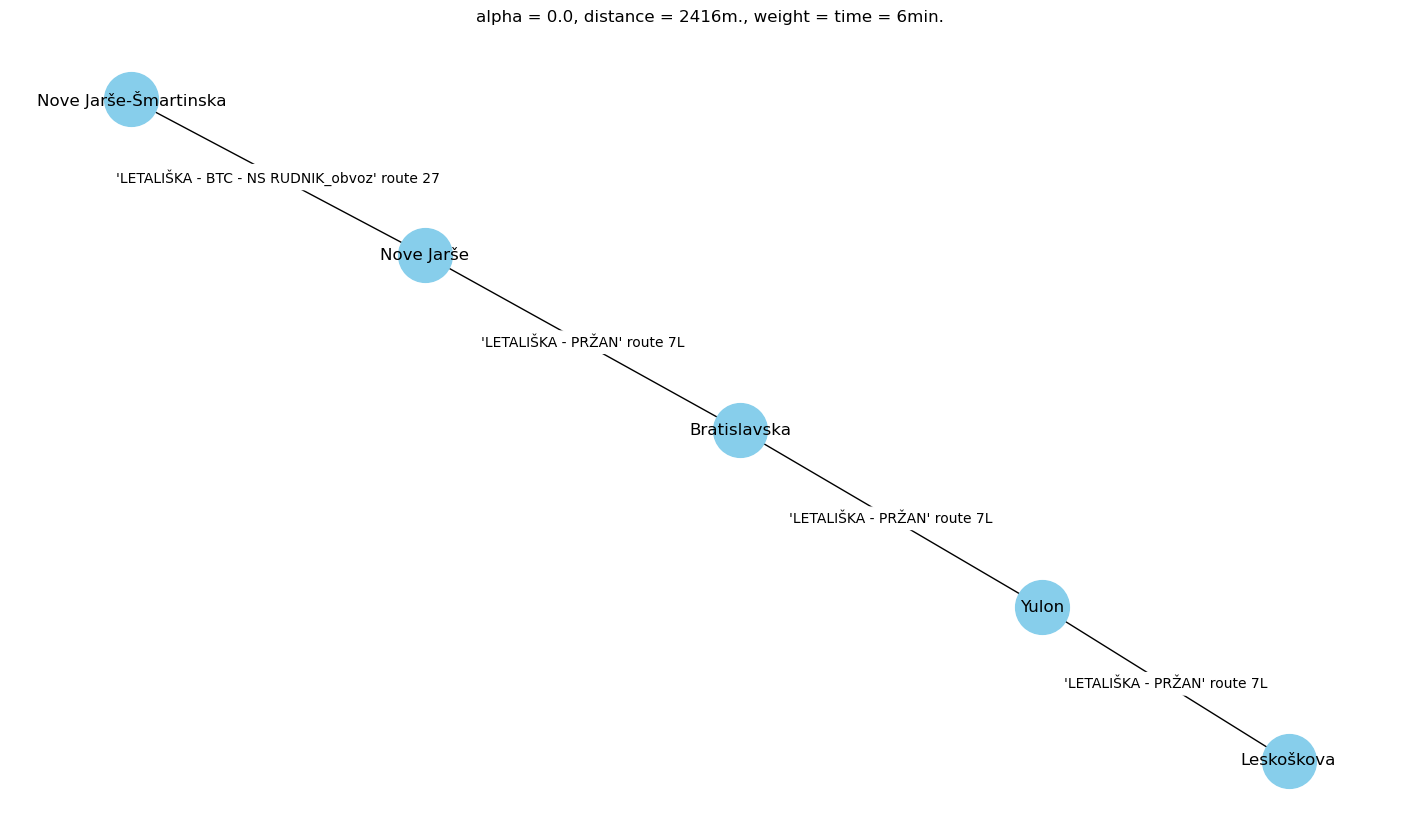

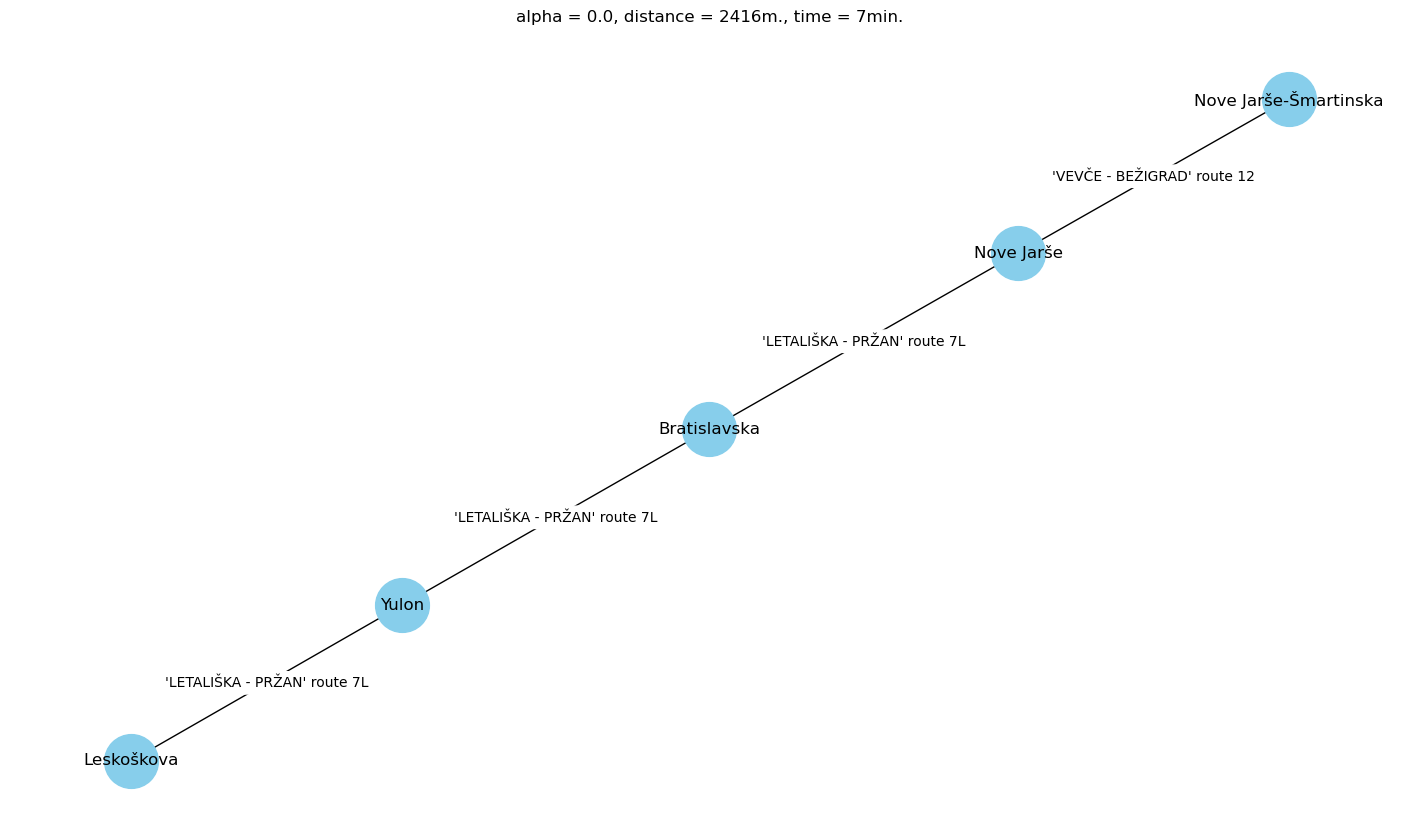

In [59]:
graphs=[
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "'LETALIŠKA - BTC - NS RUDNIK_obvoz' route 27"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 0.0, distance = 2416m., weight = time = 6min."
    },
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "'VEVČE - BEŽIGRAD' route 12"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 0.0, distance = 2416m., time = 7min."
    }
]

# Visualize each graph
for idx, graph_data in enumerate(graphs, start=1):
    G = nx.Graph()
    for node in graph_data["nodes"]:
        G.add_node(node["id"], label=node["label"])
    G.add_edges_from([(edge[0], edge[1], {"label": edge[2]}) for edge in graph_data["edges"]])

    plt.figure(idx, figsize=(14, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=1500)

    # Extract node labels for display
    node_labels = {node["id"]: node["label"] for node in graph_data["nodes"]}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, rotate=False)
    
    plt.title(graph_data["name"])
    plt.show()

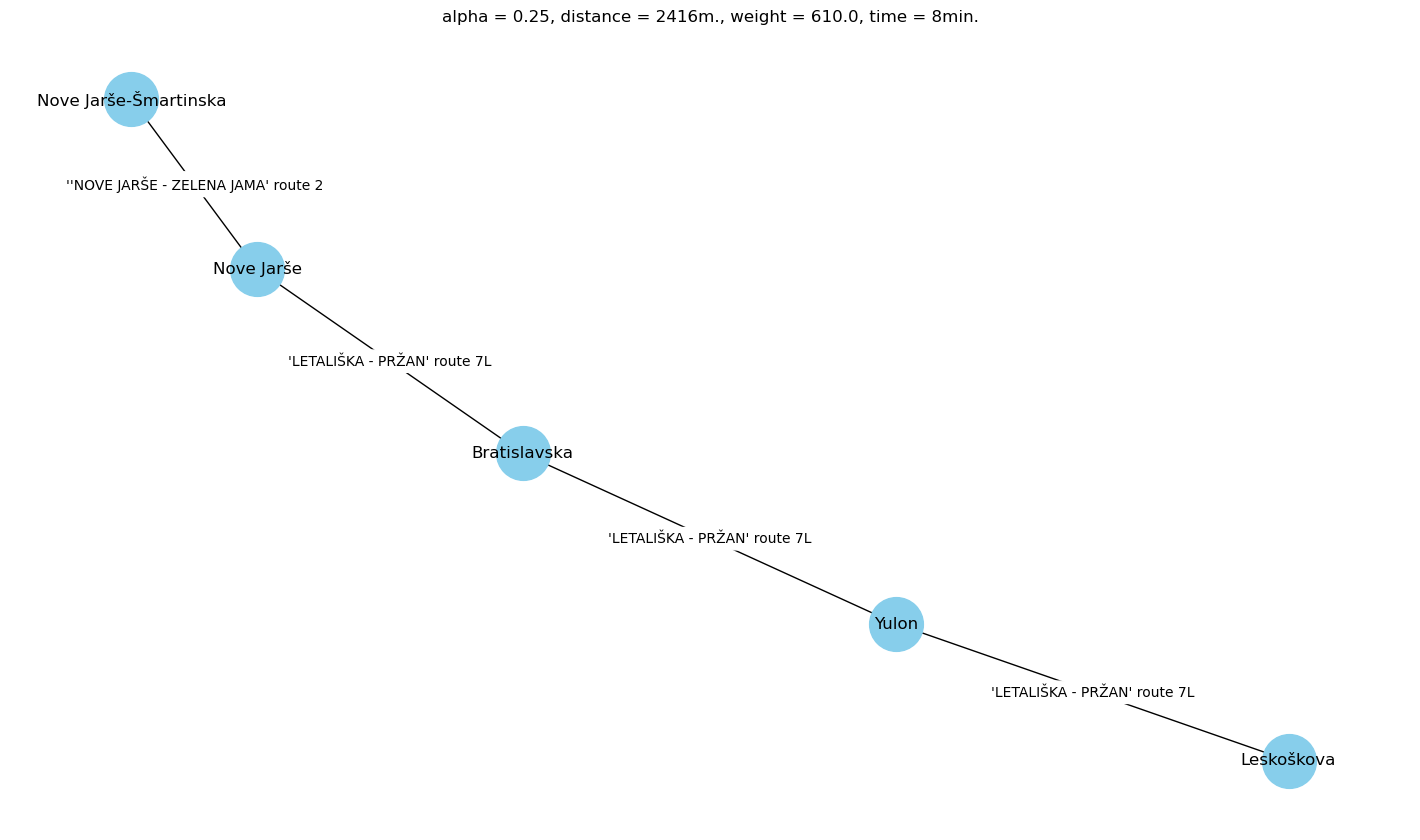

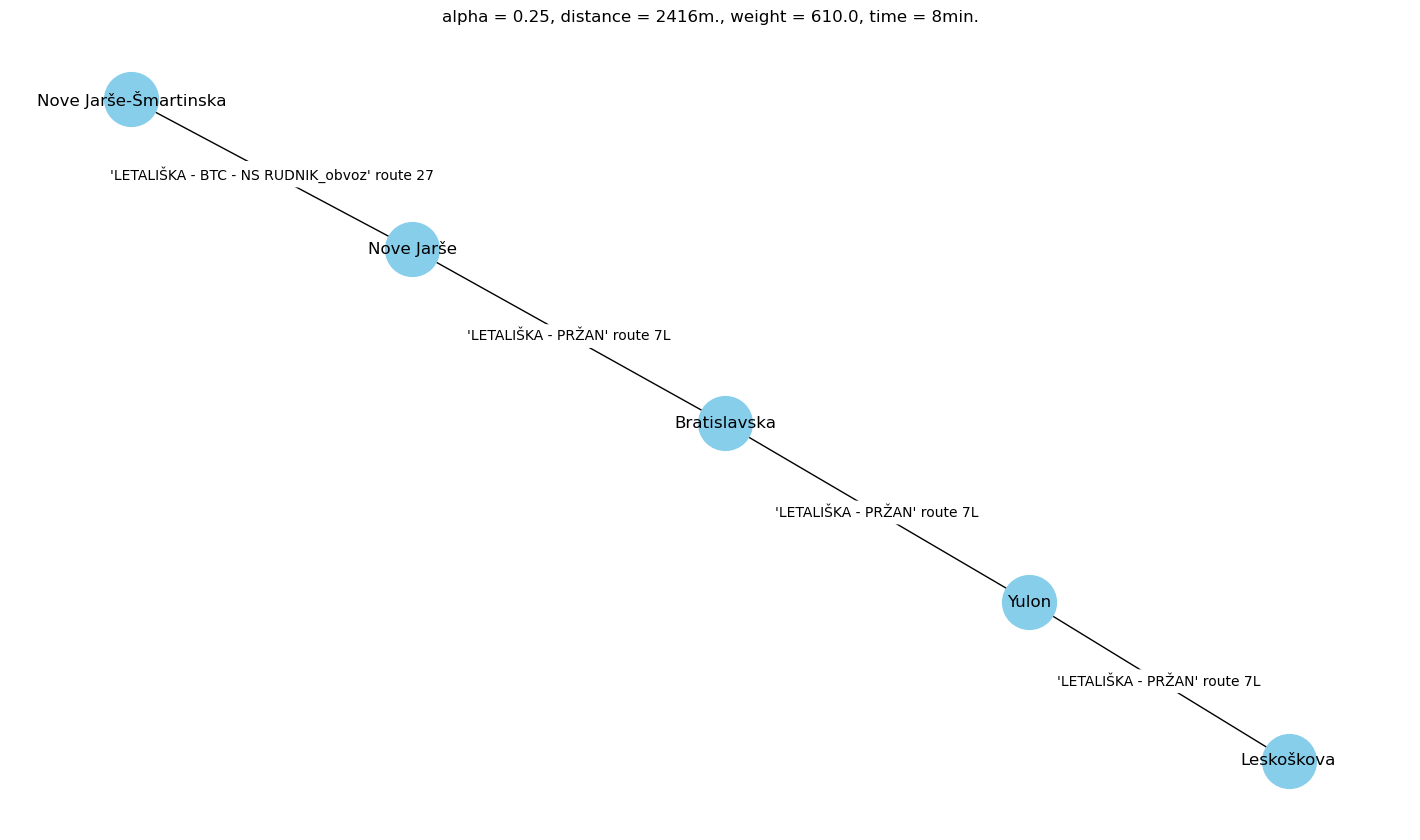

In [60]:
graphs=[
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "''NOVE JARŠE - ZELENA JAMA' route 2"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 0.25, distance = 2416m., weight = 610.0, time = 8min."
    },
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "'LETALIŠKA - BTC - NS RUDNIK_obvoz' route 27"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 0.25, distance = 2416m., weight = 610.0, time = 8min."
    }
]

# Visualize each graph
for idx, graph_data in enumerate(graphs, start=1):
    G = nx.Graph()
    for node in graph_data["nodes"]:
        G.add_node(node["id"], label=node["label"])
    G.add_edges_from([(edge[0], edge[1], {"label": edge[2]}) for edge in graph_data["edges"]])

    plt.figure(idx, figsize=(14, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=1500)

    # Extract node labels for display
    node_labels = {node["id"]: node["label"] for node in graph_data["nodes"]}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, rotate=False)
    
    plt.title(graph_data["name"])
    plt.show()

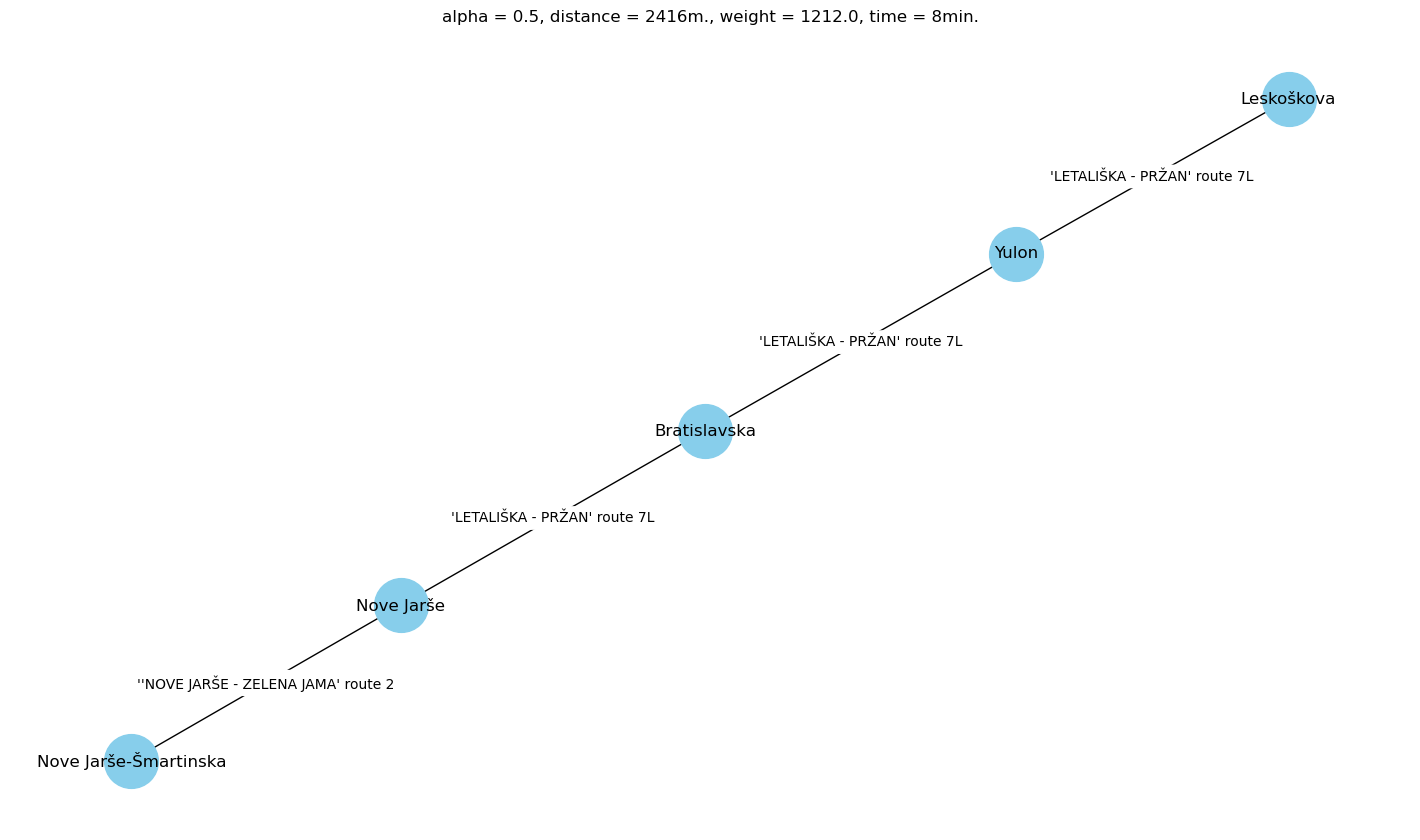

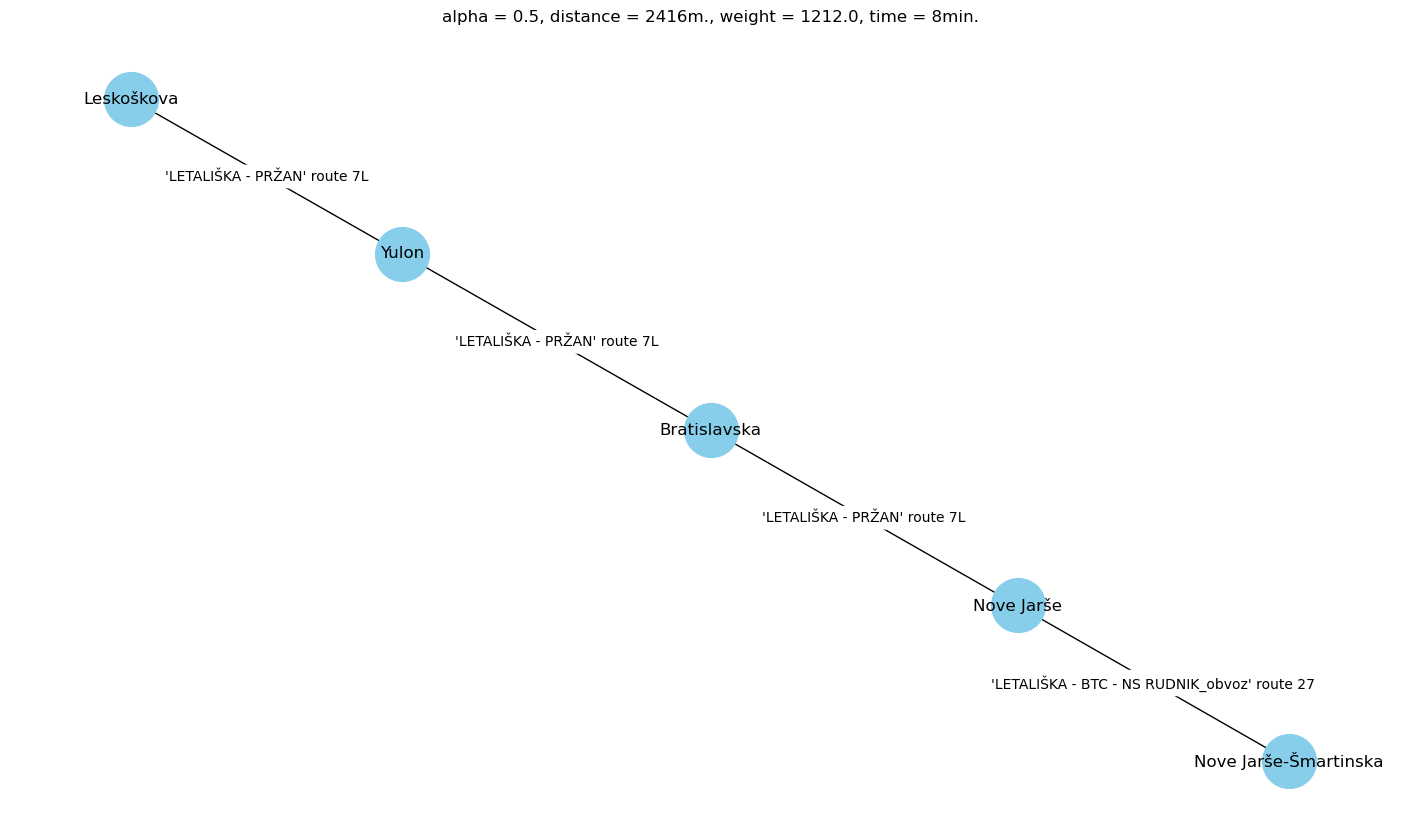

In [61]:
graphs=[
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "''NOVE JARŠE - ZELENA JAMA' route 2"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 0.5, distance = 2416m., weight = 1212.0, time = 8min."
    },
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "'LETALIŠKA - BTC - NS RUDNIK_obvoz' route 27"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 0.5, distance = 2416m., weight = 1212.0, time = 8min."
    }
]

# Visualize each graph
for idx, graph_data in enumerate(graphs, start=1):
    G = nx.Graph()
    for node in graph_data["nodes"]:
        G.add_node(node["id"], label=node["label"])
    G.add_edges_from([(edge[0], edge[1], {"label": edge[2]}) for edge in graph_data["edges"]])

    plt.figure(idx, figsize=(14, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=1500)

    # Extract node labels for display
    node_labels = {node["id"]: node["label"] for node in graph_data["nodes"]}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, rotate=False)
    
    plt.title(graph_data["name"])
    plt.show()

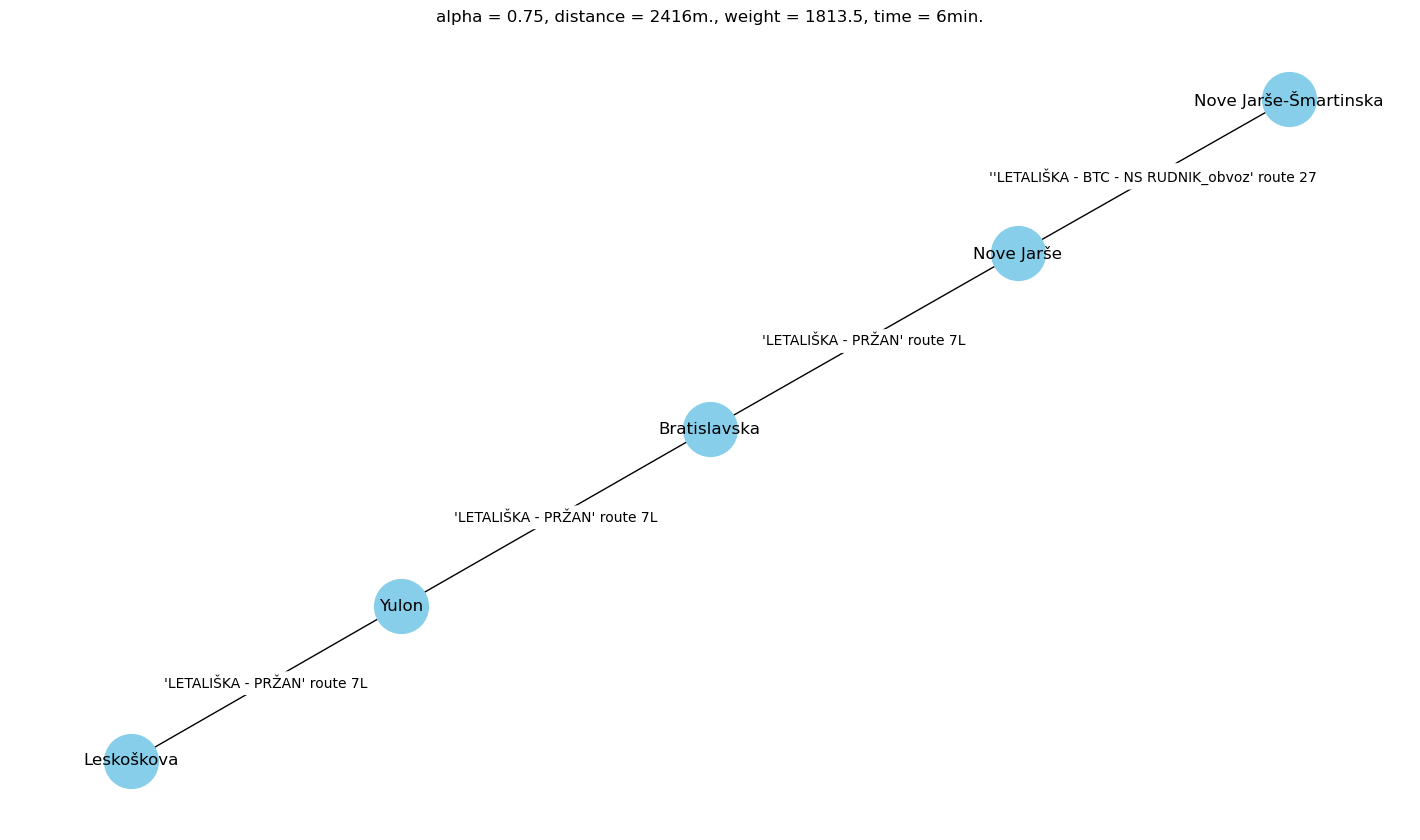

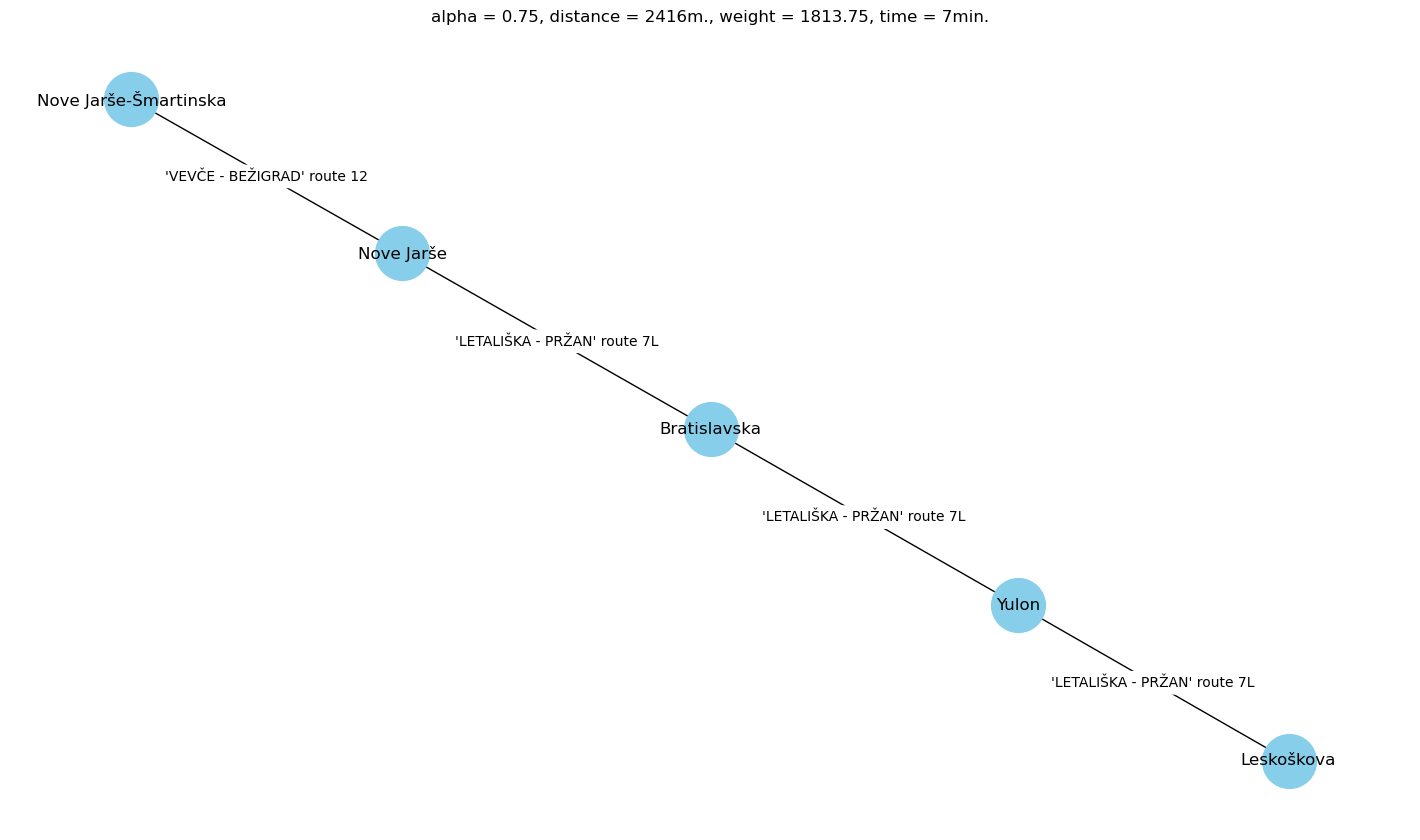

In [62]:
graphs=[
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "''LETALIŠKA - BTC - NS RUDNIK_obvoz' route 27"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 0.75, distance = 2416m., weight = 1813.5, time = 6min."
    },
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "'VEVČE - BEŽIGRAD' route 12"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 0.75, distance = 2416m., weight = 1813.75, time = 7min."
    }
]

# Visualize each graph
for idx, graph_data in enumerate(graphs, start=1):
    G = nx.Graph()
    for node in graph_data["nodes"]:
        G.add_node(node["id"], label=node["label"])
    G.add_edges_from([(edge[0], edge[1], {"label": edge[2]}) for edge in graph_data["edges"]])

    plt.figure(idx, figsize=(14, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=1500)

    # Extract node labels for display
    node_labels = {node["id"]: node["label"] for node in graph_data["nodes"]}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, rotate=False)
    
    plt.title(graph_data["name"])
    plt.show()

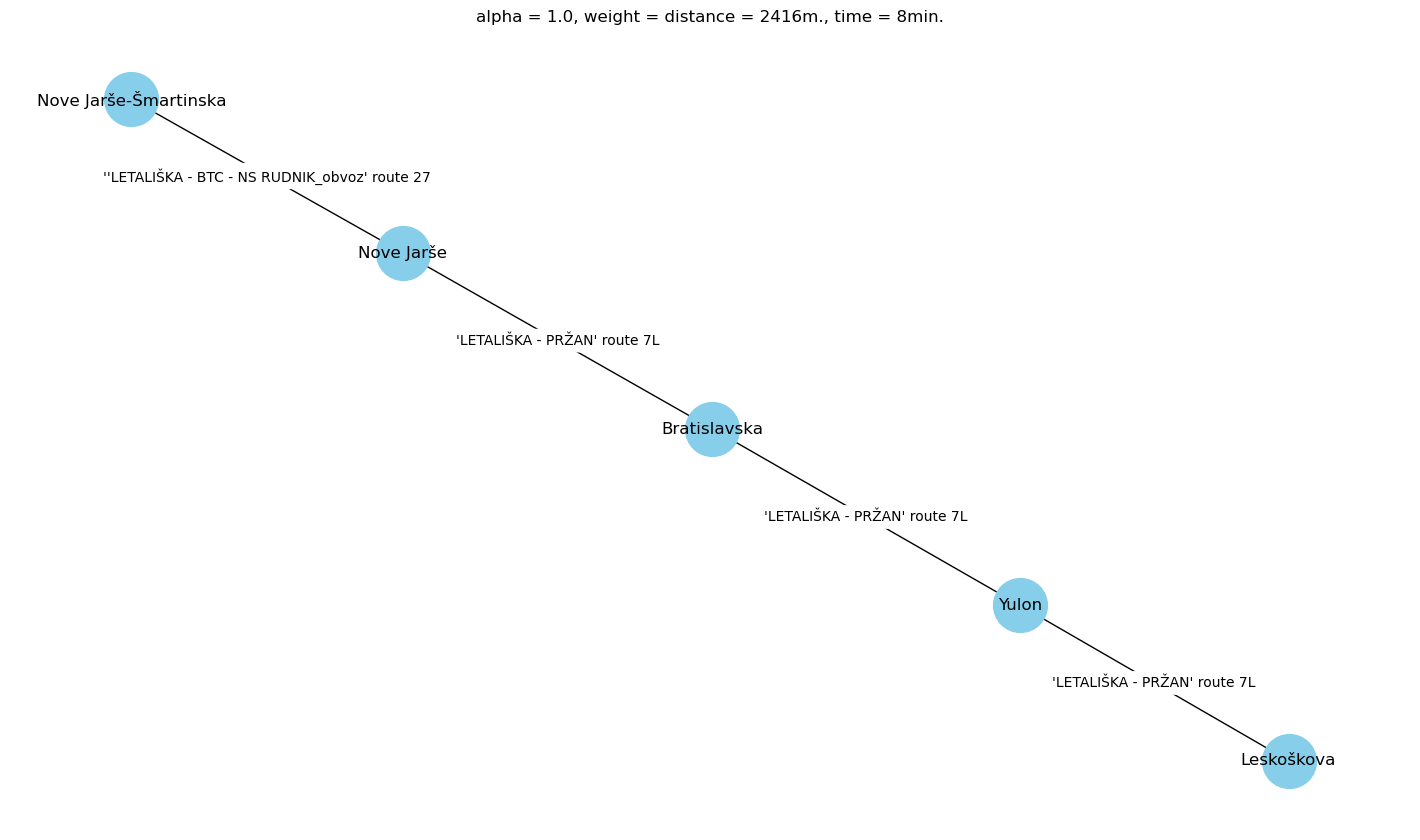

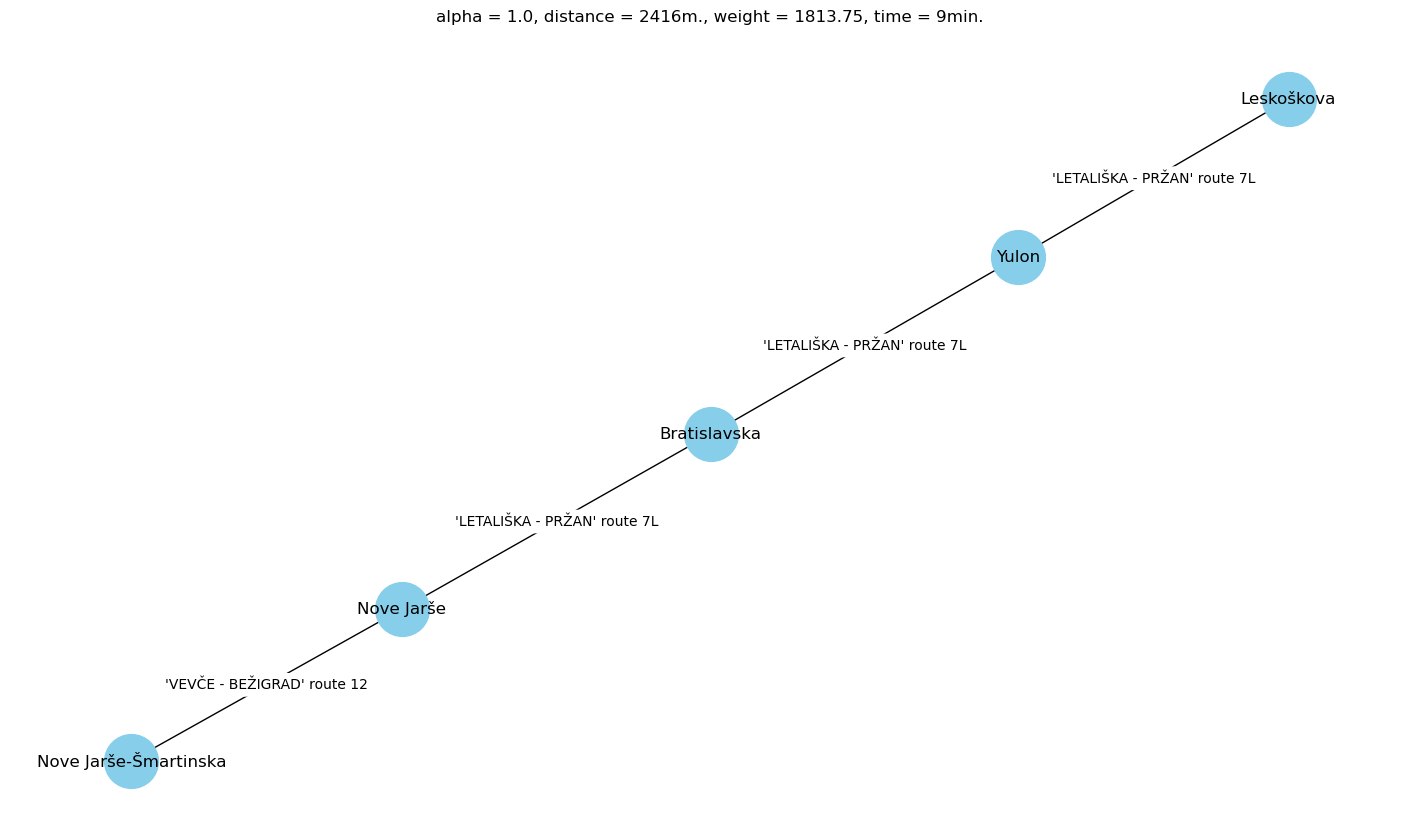

In [63]:
graphs=[
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "''LETALIŠKA - BTC - NS RUDNIK_obvoz' route 27"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 1.0, weight = distance = 2416m., time = 8min."
    },
    {
        "nodes": [
            {"id": 1, "label": "Nove Jarše-Šmartinska"},
            {"id": 2, "label": "Nove Jarše"},
            {"id": 3, "label": "Bratislavska"},
            {"id": 4, "label": "Yulon"},
            {"id": 5, "label": "Leskoškova"}
        ],
        "edges": [
            (1, 2, "'VEVČE - BEŽIGRAD' route 12"),
            (2, 3, "'LETALIŠKA - PRŽAN' route 7L"),
            (3, 4, "'LETALIŠKA - PRŽAN' route 7L"),
            (4, 5, "'LETALIŠKA - PRŽAN' route 7L")
        ],
        "name": "alpha = 1.0, distance = 2416m., weight = 1813.75, time = 9min."
    }
]

# Visualize each graph
for idx, graph_data in enumerate(graphs, start=1):
    G = nx.Graph()
    for node in graph_data["nodes"]:
        G.add_node(node["id"], label=node["label"])
    G.add_edges_from([(edge[0], edge[1], {"label": edge[2]}) for edge in graph_data["edges"]])

    plt.figure(idx, figsize=(14, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=1500)

    # Extract node labels for display
    node_labels = {node["id"]: node["label"] for node in graph_data["nodes"]}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, rotate=False)
    
    plt.title(graph_data["name"])
    plt.show()